## Estimate effect of guides from on-target knock-down

In [1]:
# import rpy2.robjects.pandas2ri
# import rpy2.robjects.numpy2ri

In [113]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import yaml
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from copy import deepcopy

mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection
from preprocess import _convert_oak_path

In [114]:
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
sgrna_library_metadata_clean = pd.read_csv('../5_sgRNA_annotation/results/sgrna_df_final.csv', index_col=0).set_index('sgRNA')
sgrna_library_metadata_clean

chromosome        pos         seq_last19bp strand    PAM  \
sgRNA                                                                
ARMC5-1        chr16   31459566  TGCCTCGCGCAGCTCGCGG      +   True   
DDB1-1         chr11   61333047  GAGTTCGCTGCGCGCTGTT      -   True   
FNDC10-1        chr1    1600078  GCCCGCTCCCCGCGATCCC      +   True   
RORC-1          chr1  151831746  CTGTGGGGCCCTGTCCATG      +   True   
SLC35F6-1       chr2   26764356  AACAGCTGGTACTTGGTCC      -   True   
...              ...        ...                  ...    ...    ...   
TYW1B-1         chr7   72744713  GCGTCGTGCAGATACTAGT      -   True   
NBPF14-1        chr1  120451417  AATATTTATCAAACAGAGG      +   True   
MUC12-2         chr7  100969567  TCTTGGTCCCTCCTGACGA      +  False   
SRGAP2-2        chr1  206463364  CACAGGTCCCGAGCCAACG      +   True   
NBPF11-2        chr1  148152266  GCCTGCAGTCCTAAACGCT      -   True   

                                                        note  flag  \
sgRNA                                                                
ARMC5-1    unique alignment, aligned to a cds but far fro...  True   
DDB1-1     unique alignment, aligned to a cds but far fro...  True   
FNDC10-1   unique alignment, aligned to a cds but far fro...  True   
RORC-1     unique alignment, aligned to a cds but far fro...  True   
SLC35F6-1  unique alignment, aligned to a cds but far fro...  True   
...                                                      ...   ...   
TYW1B-1    hg17 alignment, AtoG at pos6, aligned to a cds...  True   
NBPF14-1   hg17 alignment, AtoG at pos19, multi alignment...  True   
MUC12-2    unique alignment, target gene mismatch, aligne...  True   
SRGAP2-2   hg17 alignment, AtoG at pos11, within target g...  True   
NBPF11-2   unique alignment, target gene mismatch, aligne...  True   

                            seq target_gene_name_from_sgRNA  \
sgRNA                                                         
ARMC5-1    CTGCCTCGCGCAGCTCGCGG                       ARMC5   
DDB1-1     GGAGTTCGCTGCGCGCTGTT                        DDB1   
FNDC10-1   TGCCCGCTCCCCGCGATCCC                      FNDC10   
RORC-1     TCTGTGGGGCCCTGTCCATG                        RORC   
SLC35F6-1  GAACAGCTGGTACTTGGTCC                     SLC35F6   
...                         ...                         ...   
TYW1B-1    GGCGTCGTGCAGATACTAGT                       TYW1B   
NBPF14-1   GAATATTTATCAAACAGAGG                      NBPF14   
MUC12-2    GTCTTGGTCCCTCCTGACGA                       MUC12   
SRGAP2-2   GCACAGGTCCCGAGCCAACG                      SRGAP2   
NBPF11-2   GGCCTGCAGTCCTAAACGCT                      NBPF11   

          designed_target_gene_id  ... nearest_within2kb_gene_dist  \
sgRNA                              ...                               
ARMC5-1           ENSG00000140691  ...                        65.0   
DDB1-1            ENSG00000167986  ...                         6.0   
FNDC10-1          ENSG00000228594  ...                        57.0   
RORC-1            ENSG00000143365  ...                        56.0   
SLC35F6-1         ENSG00000213699  ...                        66.0   
...                           ...  ...                         ...   
TYW1B-1           ENSG00000277149  ...                         NaN   
NBPF14-1          ENSG00000270629  ...                         NaN   
MUC12-2           ENSG00000205277  ...                         2.0   
SRGAP2-2          ENSG00000266028  ...                         NaN   
NBPF11-2          ENSG00000263956  ...                        15.0   

           nearest_within2kb_nontarget_gene_id  \
sgRNA                                            
ARMC5-1                                    NaN   
DDB1-1                         ENSG00000149476   
FNDC10-1                                   NaN   
RORC-1                                     NaN   
SLC35F6-1                      ENSG00000115163   
...                                        ...   
TYW1B-1                                    NaN   
NBPF14-

In [115]:
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)
# Read config for both experiments
experiment_names = ['CD4iR1_Psomagen', 'CD4iR2_Psomagen']
sample_info_list = []

for experiment_name in experiment_names:
    # Get config for this experiment
    config_exp = config[experiment_name]
    datadir = _convert_oak_path(config_exp['datadir'])
    
    # Find all postQC h5ad files in tmp directory
    tmp_dir = os.path.join(datadir, 'tmp')
    h5ad_files = [f for f in os.listdir(tmp_dir) if f.endswith('.postQC.h5ad')]
    
    for h5ad_file in h5ad_files:
        # Read h5ad file to get culture condition
        culture_condition = h5ad_file.split('_')[3]
        
        # Get sample ID from filename
        sample_id = h5ad_file.replace('.scRNA.postQC.h5ad', '')
        
        sample_info_list.append({
            'sample_id': sample_id,
            'culture_condition': culture_condition,
            'datadir': datadir,
            'experiment': experiment_name
        })

# Combine all sample info into one dataframe
sample_info_df = pd.DataFrame(sample_info_list)

len(sample_info_df[sample_info_df['culture_condition'] == 'Rest'])

94

In [123]:
def get_sample_stats(datadir, sample_id):
    """
    Calculate guide and NTC statistics for a single sample.
    
    Args:
        datadir (str): Path to data directory
        sample_id (str): Sample ID
        
    Returns:
        tuple: (sample_guide_sums, sample_guide_sums_sq, sample_n_cells, 
                sample_ntc_sums, sample_ntc_sums_sq)
    """
    f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
    adata = anndata.experimental.read_lazy(f)
    adata.obs = adata.obs.to_dataframe()
    adata.var = adata.var.to_dataframe()

    targeting_mask = adata.obs['guide_type'] == 'targeting'
    cell2guide = pd.get_dummies(adata[targeting_mask].obs['guide_id']).astype(int)
    target_gene_values = adata[targeting_mask].obs['target_lognorm_expr'].values

    # Calculate statistics for this sample
    sample_guide_sums = pd.DataFrame(
        target_gene_values.reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_guide_sums_sq = pd.DataFrame(
        (target_gene_values ** 2).reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_n_cells = pd.DataFrame(
        cell2guide.sum(axis=0),
        index=cell2guide.columns,
        columns=[sample_id]
    )

    sample_ntc_sums = pd.DataFrame(
        adata.var['sum_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums_sq = pd.DataFrame(
        adata.var['sum_sq_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums.loc['n_ntc_cells'] = adata.uns['n_ntc']
    
    return (sample_guide_sums, sample_guide_sums_sq, sample_n_cells,
            sample_ntc_sums, sample_ntc_sums_sq)

In [138]:
results_dir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_Psomagen' 


In [139]:

# Process each sample
for c in ['Rest', 'Stim8hr', 'Stim48hr']:
    # Initialize empty dataframes to store results for all samples
    guide_sums_df = pd.DataFrame()
    guide_sums_sq_df = pd.DataFrame()
    n_cells_guide_df = pd.DataFrame()
    ntc_sums_df = pd.DataFrame()  
    ntc_sums_sq_df = pd.DataFrame() 
    
    for it in tqdm(sample_info_df[sample_info_df.culture_condition == c].iterrows(), desc=f"Processing {c} samples"):
        i,x = it
        sample_guide_sums, sample_guide_sums_sq, sample_n_cells, sample_ntc_sums, sample_ntc_sums_sq = get_sample_stats(x['datadir'], x['sample_id'])
        # Concatenate with existing results
        guide_sums_df = pd.concat([guide_sums_df, sample_guide_sums], axis=1)
        guide_sums_sq_df = pd.concat([guide_sums_sq_df, sample_guide_sums_sq], axis=1)
        n_cells_guide_df = pd.concat([n_cells_guide_df, sample_n_cells], axis=1)
        ntc_sums_df = pd.concat([ntc_sums_df, sample_ntc_sums], axis=1)  
        ntc_sums_sq_df = pd.concat([ntc_sums_sq_df, sample_ntc_sums_sq], axis=1)  

    # Get summary stats for each guide
    total_guide_sums = guide_sums_df.fillna(0).sum(1)
    total_guide_sums_sq = guide_sums_sq_df.fillna(0).sum(1)
    total_guide_n = n_cells_guide_df.fillna(0).sum(1)
    guide_mean_expr = total_guide_sums / total_guide_n
    guide_std_expr = np.sqrt((total_guide_sums_sq - total_guide_sums**2 / total_guide_n) / (total_guide_n - 1))
    guide_std_expr = guide_std_expr.fillna(100) # cases with one cell with guide
    guide_std_expr = pd.Series(np.where(guide_std_expr == 0, 0.01, guide_std_expr), index=guide_std_expr.index)

    # Get summary stats for expression in NTCs
    total_ntc_sums = ntc_sums_df.drop('n_ntc_cells').fillna(0).sum(1) 
    total_ntc_sums_sq = ntc_sums_sq_df.fillna(0).sum(1) 
    total_ntc_n = ntc_sums_df.loc['n_ntc_cells'].sum()
    ntc_mean_expr = total_ntc_sums / total_ntc_n
    ntc_std_expr = np.sqrt((total_ntc_sums_sq - total_ntc_sums**2 / total_ntc_n) / (total_ntc_n - 1))
    ntc_std_expr = ntc_std_expr.fillna(100) # cases with one cell with guide

    perturbed_genes = sgrna_library_metadata.set_index('sgrna_id').loc[guide_mean_expr.index]['perturbed_gene_id'].values
    ntc_mean_expr = ntc_mean_expr.reindex(perturbed_genes, fill_value=0)
    ntc_mean_expr.index = guide_mean_expr.index
    ntc_std_expr = ntc_std_expr.reindex(perturbed_genes, fill_value=0)
    ntc_std_expr.index = guide_mean_expr.index

    ttest_df = pd.concat([guide_mean_expr, guide_std_expr, total_guide_n, ntc_mean_expr, ntc_std_expr], axis=1, 
                        keys=['guide_mean_expr', 'guide_std_expr', 'guide_n', 'ntc_mean_expr', 'ntc_std_expr'])
    ttest_df['ntc_n'] = total_ntc_n

    # Calculate Welch's t-test for each row
    t_stats = []
    p_values = []
    for _, row in ttest_df.iterrows():
        t_stat, p_value = stats.ttest_ind_from_stats(
            row['guide_mean_expr'], row['guide_std_expr'], row['guide_n'],
            row['ntc_mean_expr'], row['ntc_std_expr'], row['ntc_n'],  # Using std=1.0 for NTCs
            equal_var=False)
        t_stats.append(t_stat)
        p_values.append(p_value)

    ttest_df['t_statistic'] = t_stats
    ttest_df['p_value'] = p_values

    # Compute Benjamini-Hochberg adjusted p-values
    valid_pvals = ttest_df['p_value'].dropna()
    _, adj_pvals, _, _ = multipletests(valid_pvals, method='fdr_bh')
    ttest_df.loc[valid_pvals.index, 'adj_p_value'] = adj_pvals
    ttest_df['signif_knockdown'] = (ttest_df['adj_p_value'] < 0.1) & (ttest_df['t_statistic'] < 0)
    ttest_df['adj_p_value'] = np.where(ttest_df['adj_p_value'] < 1e-16, 1e-16, ttest_df['adj_p_value'])

    # Save ttest_df for condition
    ttest_df.to_csv(f'{results_dir}/{experiment_name}.guide_effect.{c}.csv')

Processing Rest samples: 0it [00:00, ?it/s]

Processing Stim8hr samples: 0it [00:00, ?it/s]

Processing Stim48hr samples: 0it [00:00, ?it/s]

<Axes: xlabel='guide_mean_expr', ylabel='guide_std_expr'>

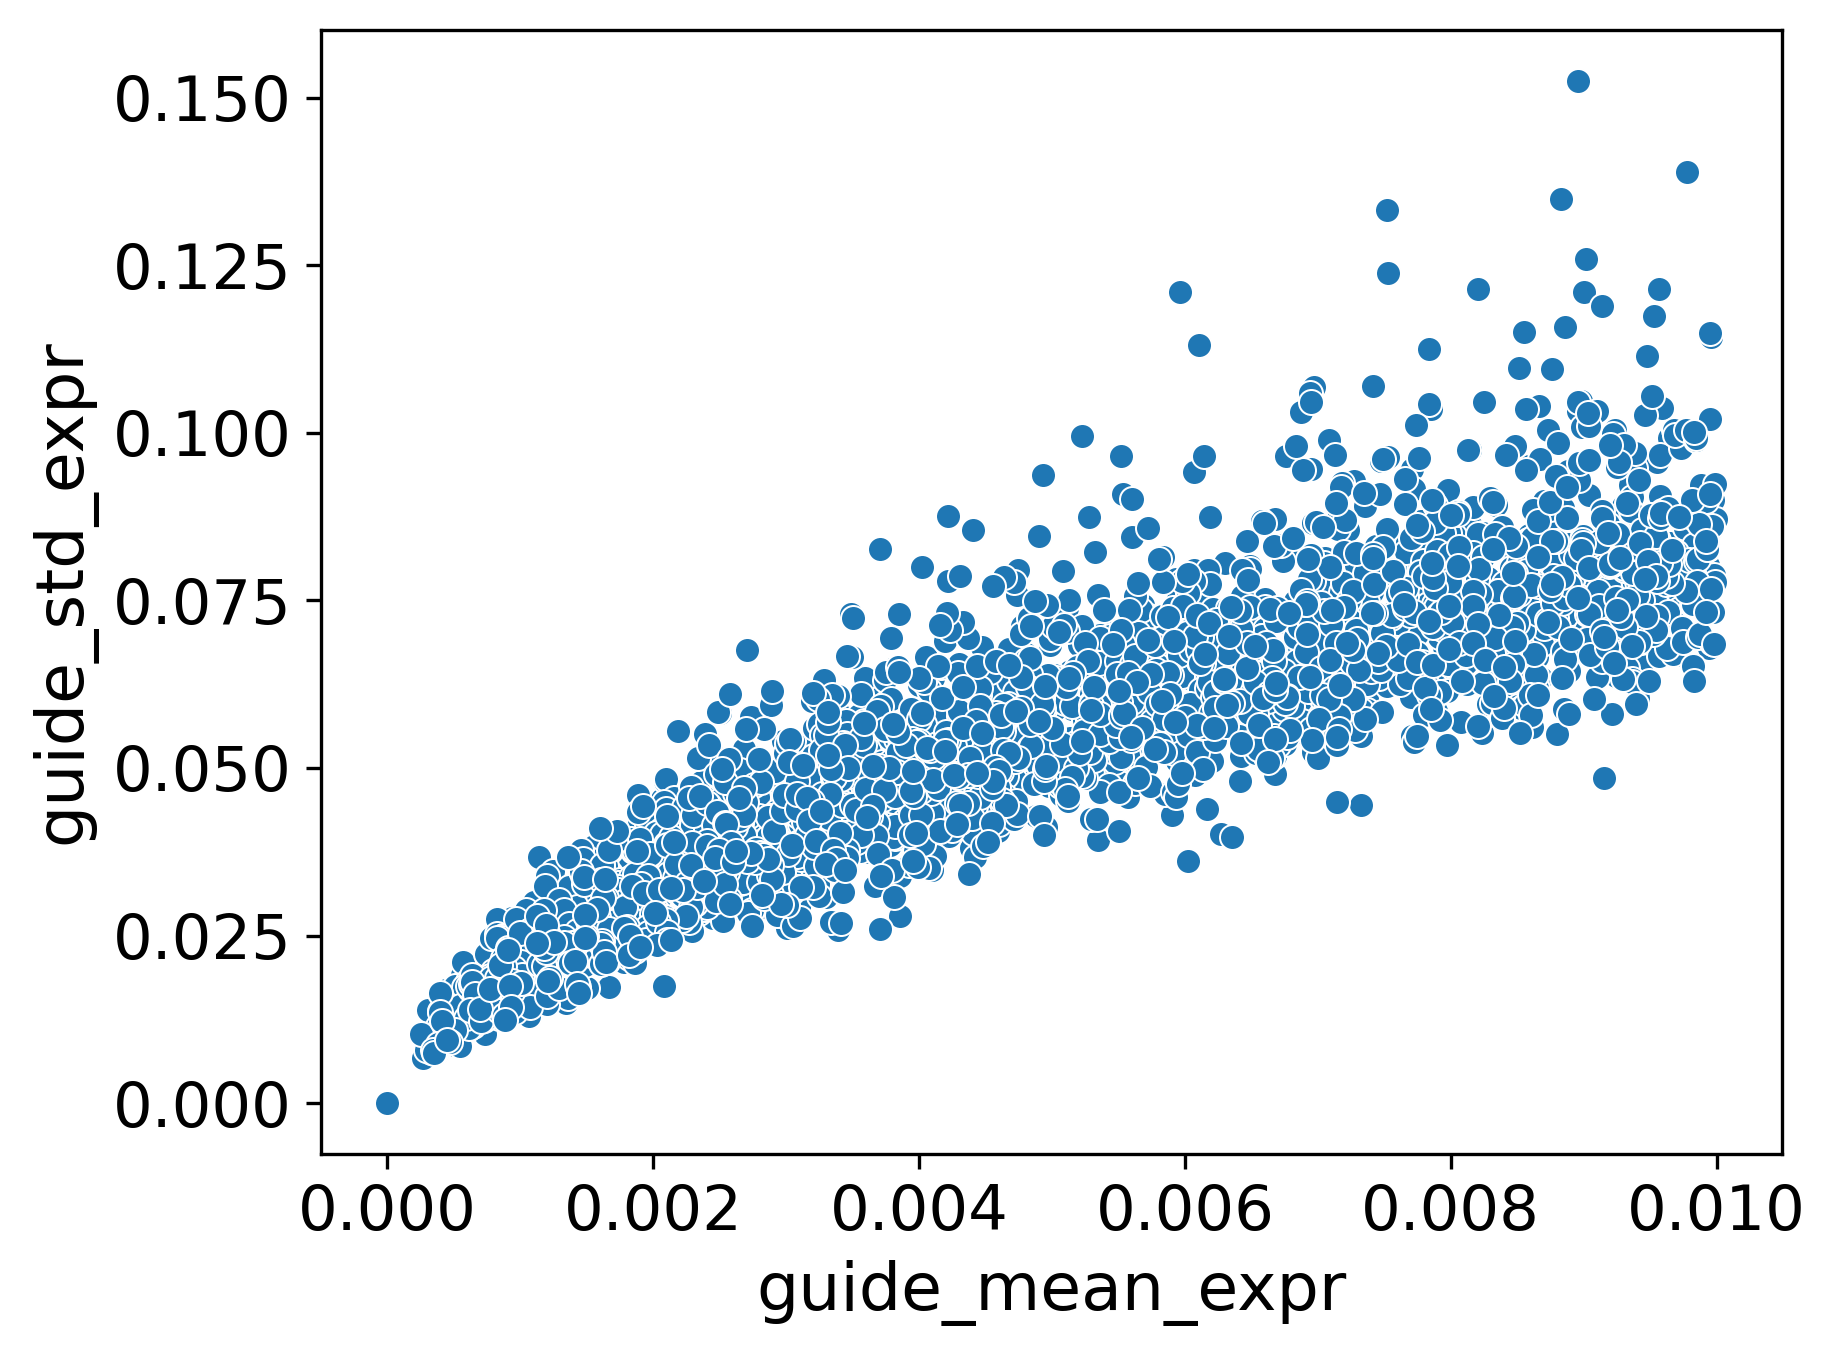

In [140]:
sns.scatterplot(data=stim_ttest_df[(stim_ttest_df.guide_std_expr < 100) & (stim_ttest_df.guide_mean_expr < 0.01)], x='guide_mean_expr', y='guide_std_expr')

In [141]:
stim_ttest_df = pd.read_csv(f'{results_dir}/{experiment_name}.guide_effect.Stim8hr.csv', index_col=0)
stim48_ttest_df = pd.read_csv(f'{results_dir}/{experiment_name}.guide_effect.Stim48hr.csv', index_col=0)
rest_ttest_df = pd.read_csv(f'{results_dir}/{experiment_name}.guide_effect.Rest.csv', index_col=0)
stim_ttest_df.to_csv(f'{results_dir}/CD4i_final.guide_effect.Stim8hr.csv')
stim48_ttest_df.to_csv(f'{results_dir}/CD4i_final.guide_effect.Stim48hr.csv')
rest_ttest_df.to_csv(f'{results_dir}/CD4i_final.guide_effect.Rest.csv')

print(rest_ttest_df.signif_knockdown.value_counts())
print(stim_ttest_df.signif_knockdown.value_counts())
print(stim48_ttest_df.signif_knockdown.value_counts())

stim_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[stim_ttest_df.index]['perturbed_gene_id']
stim48_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[stim48_ttest_df.index]['perturbed_gene_id']
rest_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[rest_ttest_df.index]['perturbed_gene_id']

signif_knockdown
True     17723
False     6764
Name: count, dtype: int64
signif_knockdown
True     18325
False     6376
Name: count, dtype: int64
signif_knockdown
True     18046
False     6531
Name: count, dtype: int64


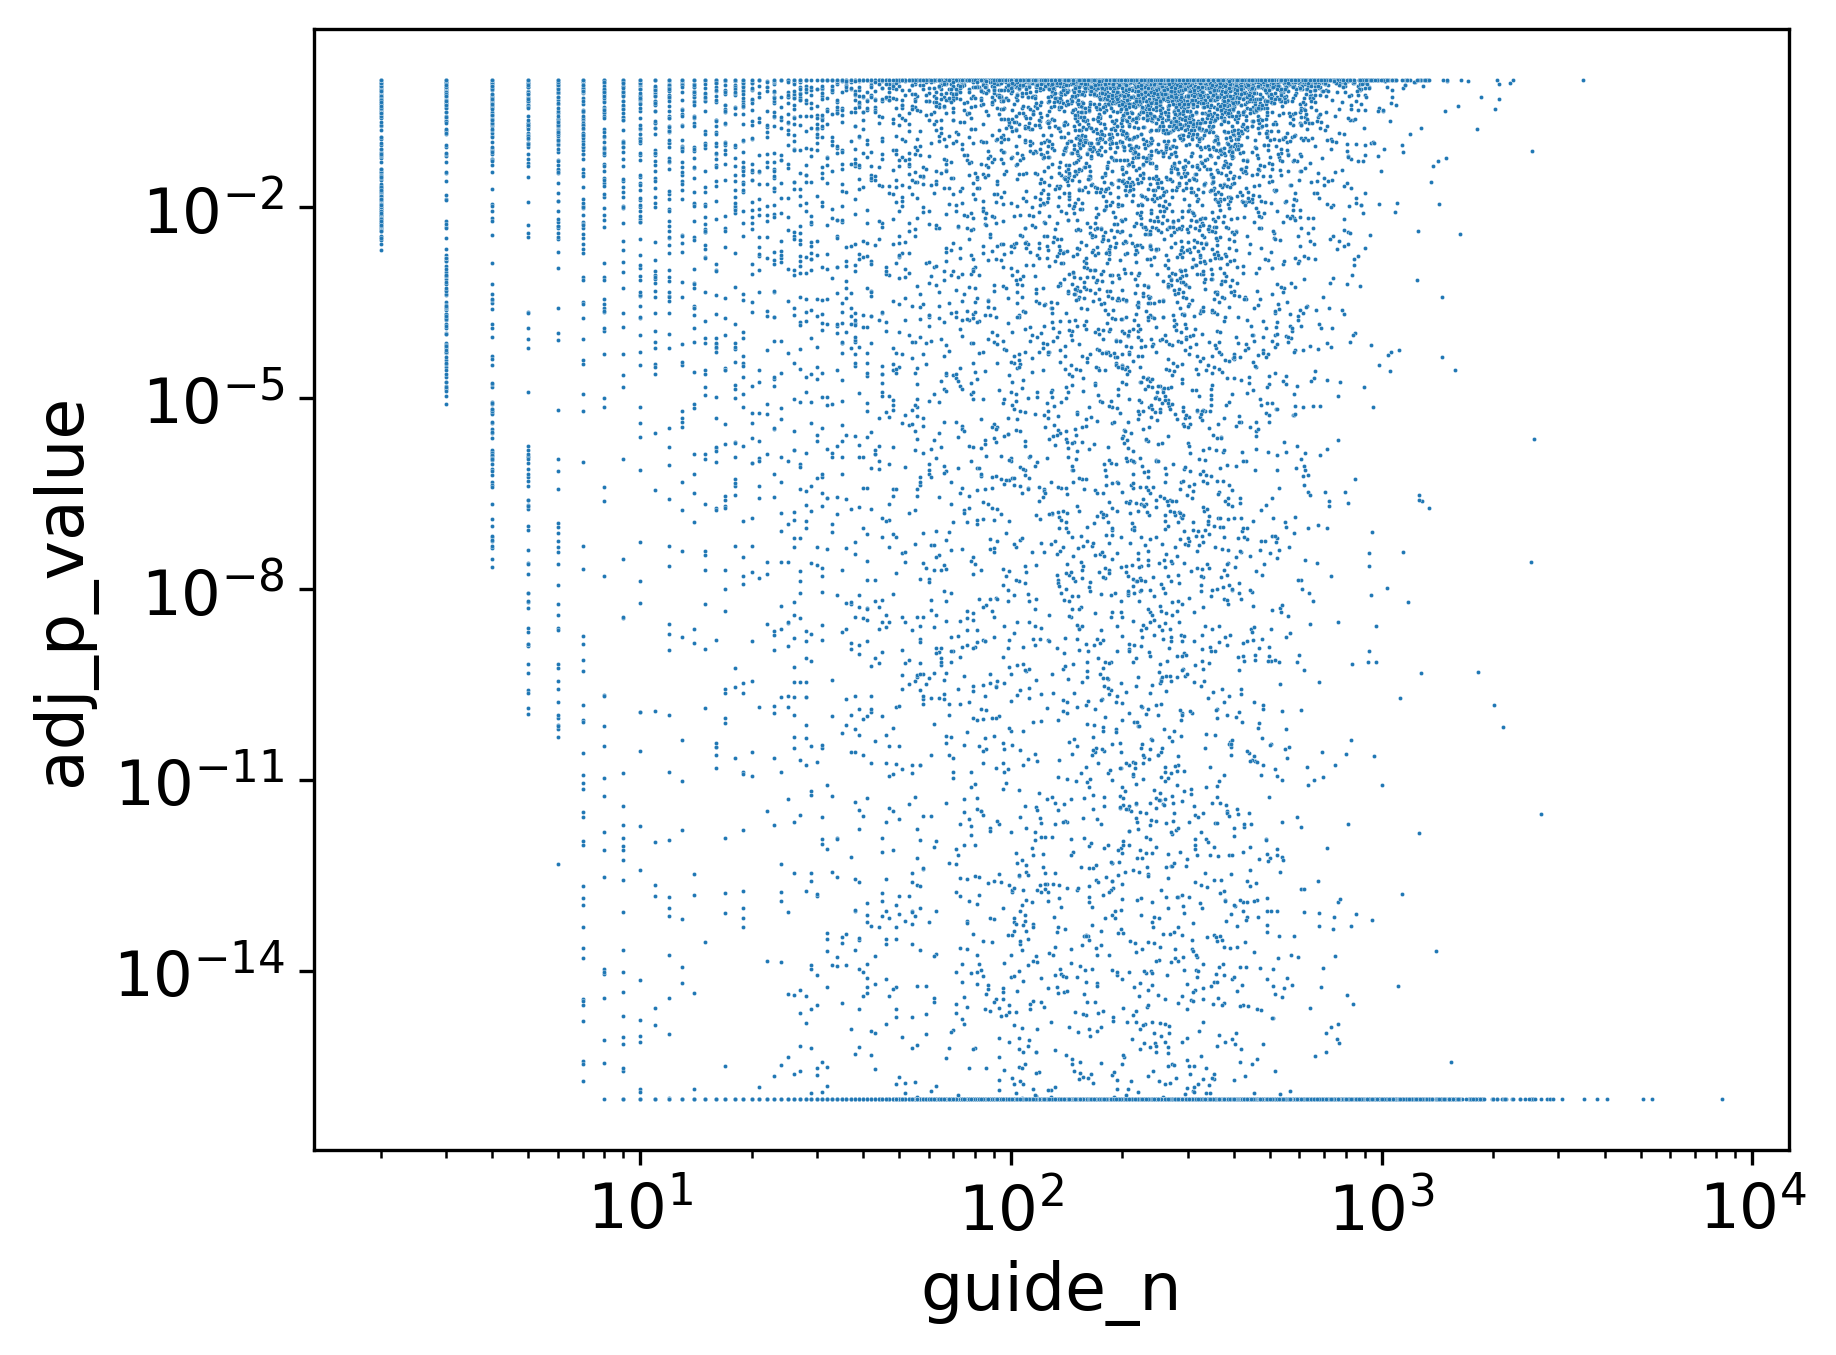

In [142]:
sns.scatterplot(data=stim_ttest_df, x='guide_n', y='adj_p_value', s=1);
plt.xscale('log')
plt.yscale('log')

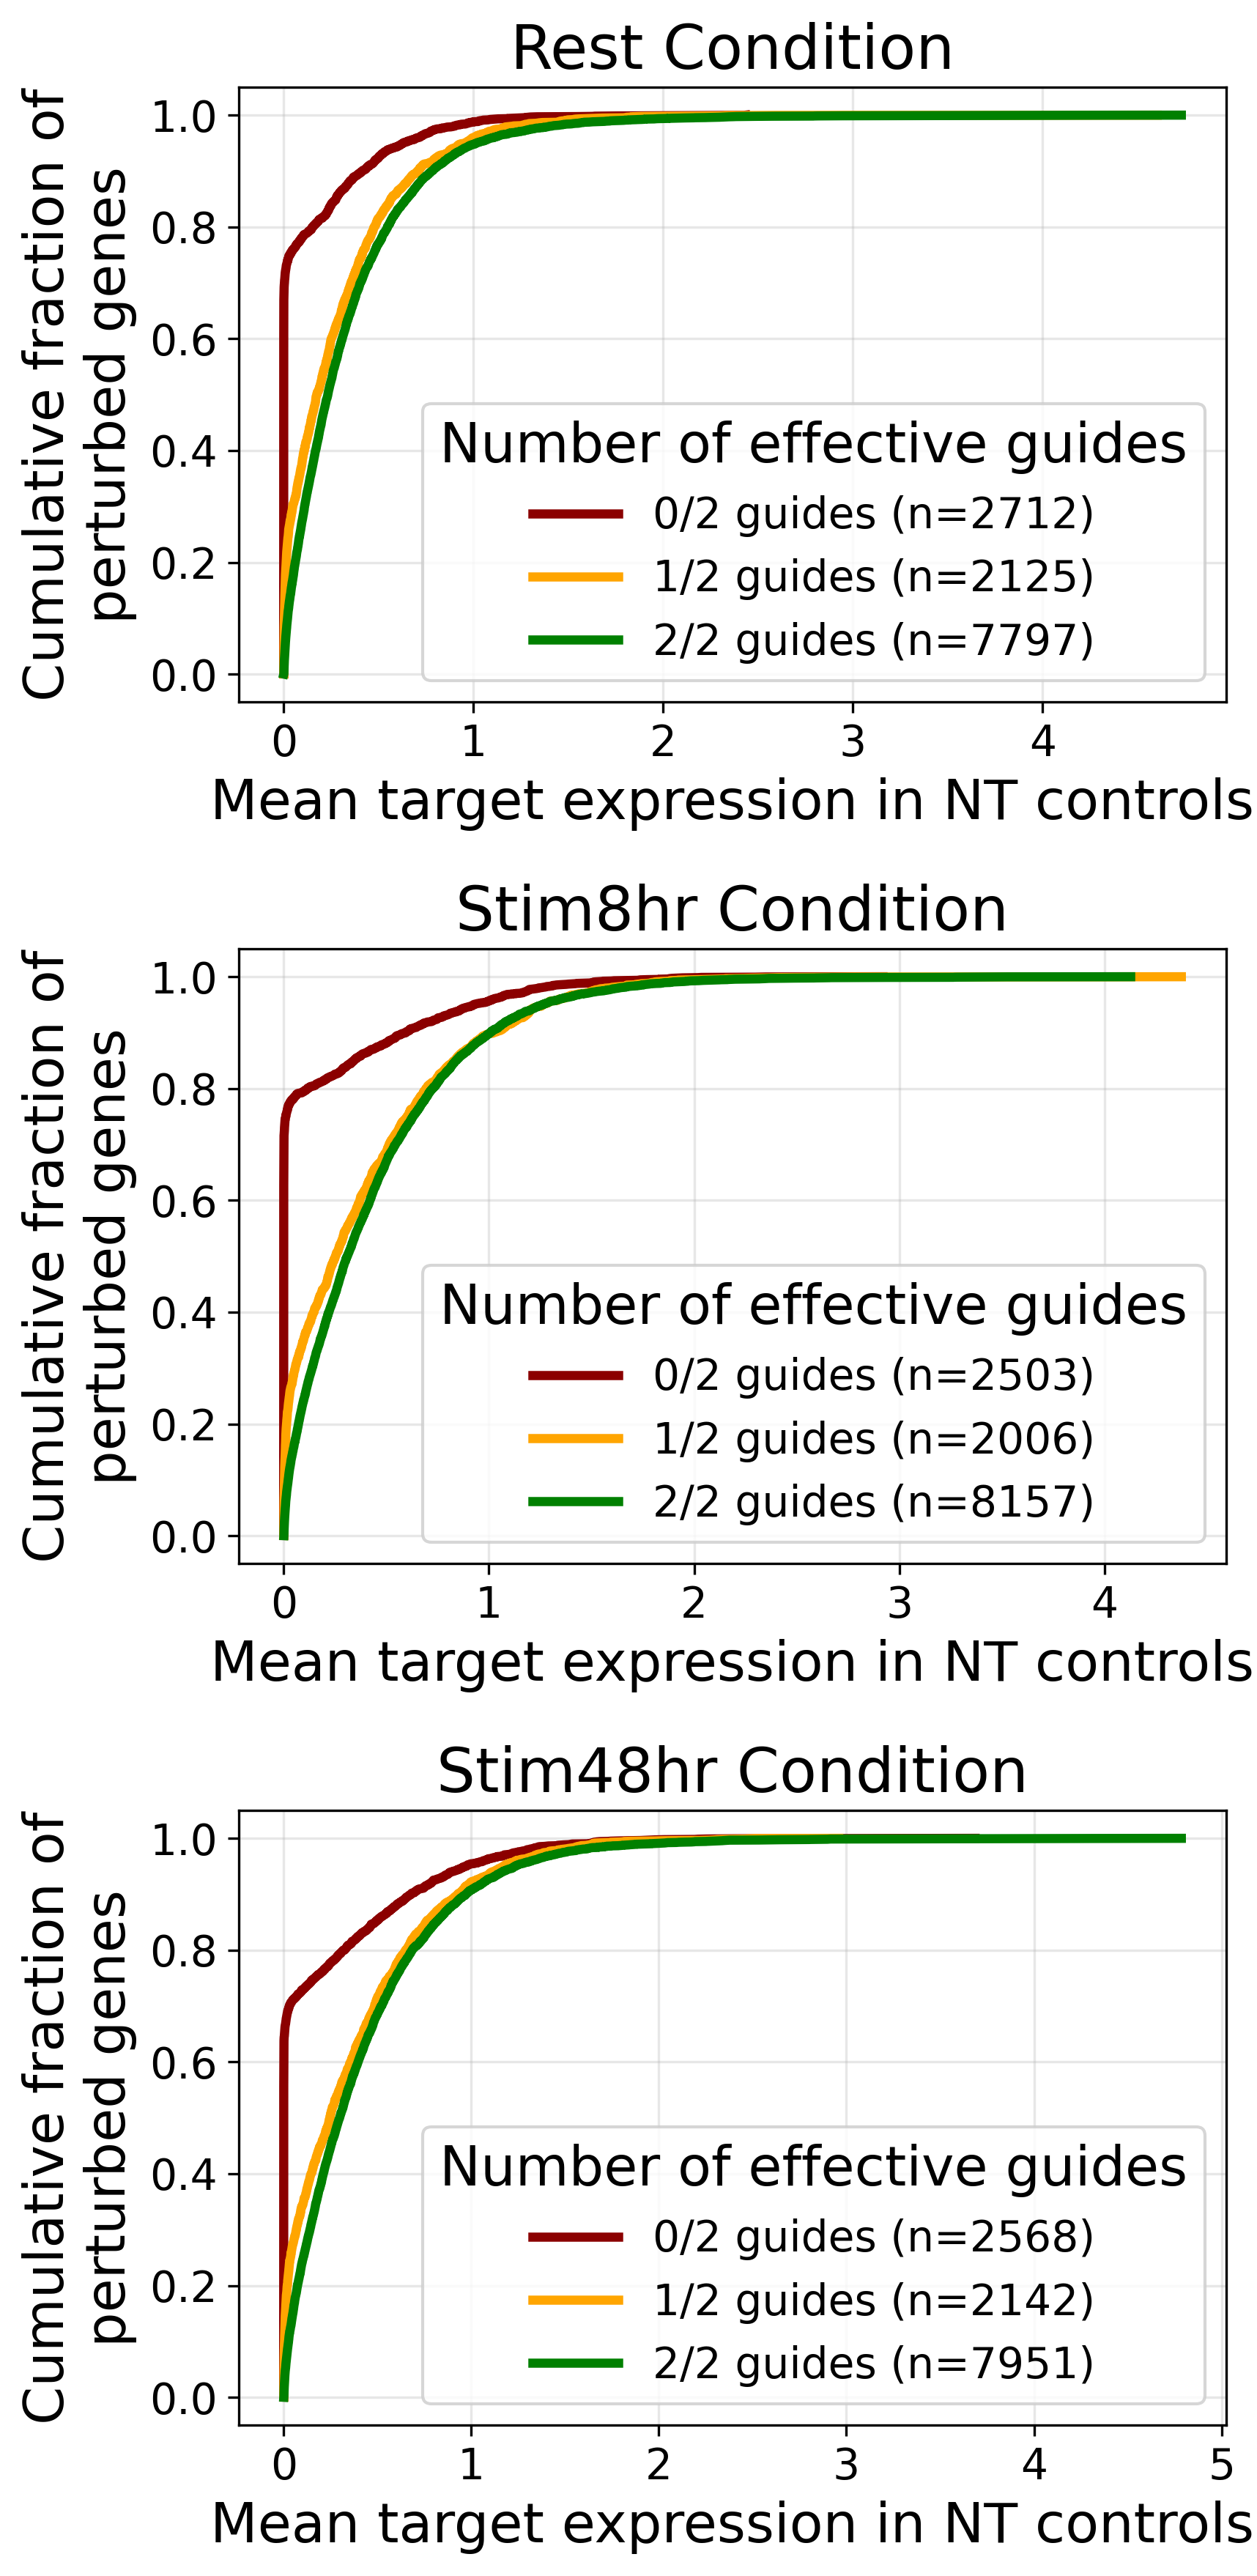

In [143]:
# Create figure with 2 subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))

# Function to create the plot for a given dataframe and axis
def plot_cumulative_dist(df, ax, title):
    pl_df = df.groupby('perturbed_gene_id').agg({
        'ntc_mean_expr': 'mean',
        'signif_knockdown': 'sum'
    })
    pl_df['signif_knockdown'] = np.where(pl_df['signif_knockdown'] > 2, 2, pl_df['signif_knockdown'])

    colors = {2: 'green', 1: 'orange', 0: 'darkred'}
    for knockdown in sorted(pl_df['signif_knockdown'].unique()):
        subset = pl_df[pl_df['signif_knockdown'] == knockdown]
        x = np.sort(subset['ntc_mean_expr'])
        y = np.arange(1, len(x) + 1) / len(x)
        ax.plot(x, y, 
                label=f'{knockdown}/2 guides (n={len(subset)})', 
                linewidth=3,
                color=colors[knockdown])

    ax.set_xlabel('Mean target expression in NT controls', fontsize=18)
    ax.set_ylabel('Cumulative fraction of\nperturbed genes', fontsize=18)
    ax.legend(title='Number of effective guides', fontsize=14, title_fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(title, fontsize=20)

# Plot for both conditions
plot_cumulative_dist(rest_ttest_df, ax1, 'Rest Condition')
plot_cumulative_dist(stim_ttest_df, ax2, 'Stim8hr Condition')
plot_cumulative_dist(stim48_ttest_df, ax3, 'Stim48hr Condition')

plt.tight_layout()
plt.savefig('../../results/CD4i_final/target_expression_ecdf.pdf')
plt.savefig('../../results/CD4i_final/target_expression_ecdf.png')

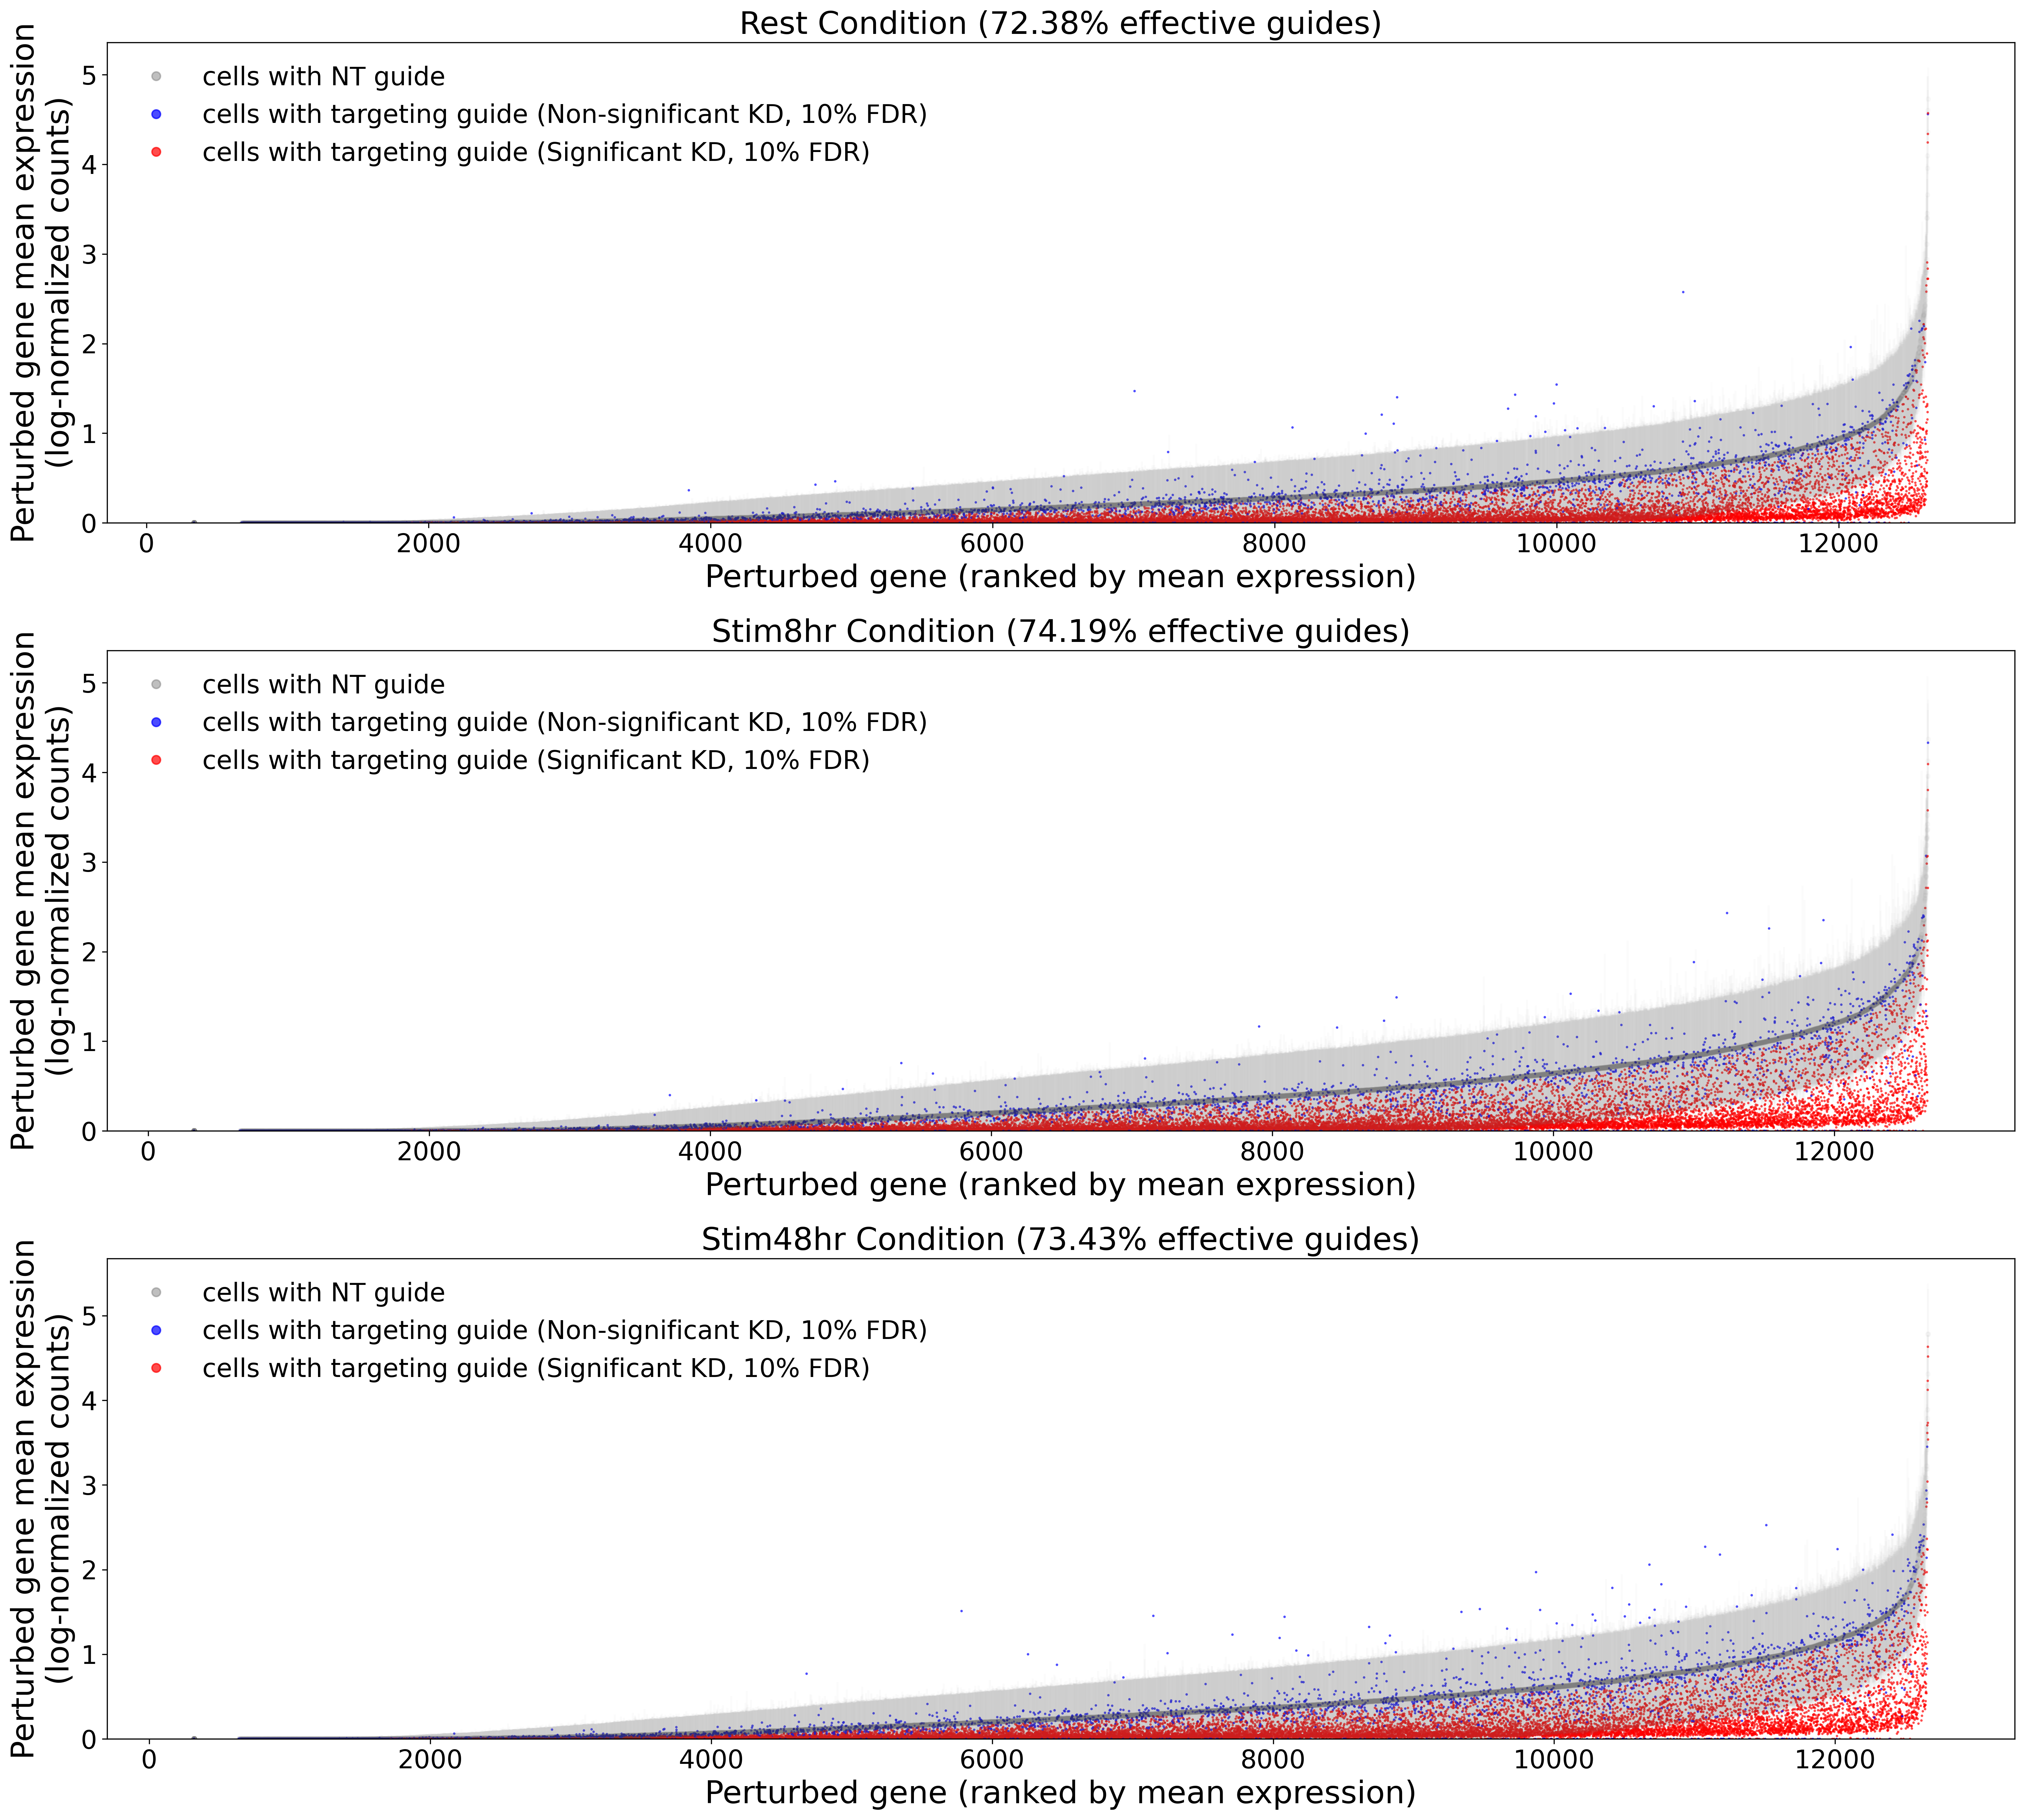

In [144]:

# Function to create the plot for a given dataframe and axis
def plot_expression_rank(df, ax, title):
    # Get unique perturbed genes and their mean NTC expression
    gene_ntc_means = df.groupby('perturbed_gene_id')['ntc_mean_expr'].mean()
    # Rank the perturbed genes by their mean NTC expression
    gene_ranks = gene_ntc_means.rank()
    # Map the gene ranks back to the original dataframe
    df['rank'] = df['perturbed_gene_id'].map(gene_ranks)

    # Plot mean NTC expression with error bars
    ax.errorbar(df['rank'],
                df['ntc_mean_expr'], 
                yerr=df['ntc_std_expr'], 
                fmt='o',
                color='grey',
                markersize=3, 
                alpha=0.01,
                label='NT control cells',
                rasterized=True)

    # Color points based on significance
    sns.scatterplot(
        data=df, 
        y='guide_mean_expr', 
        x='rank',
        s=3, 
        hue='signif_knockdown',
        palette={True: 'red', False: 'blue'},
        hue_order=[True, False],
        legend=False,
        alpha=0.7,
        linewidth=0,
        ax=ax,
        rasterized=True)

    # Add legend
    ax.legend([plt.Line2D([0], [0], marker='o', color='grey', linestyle='', alpha=0.5),
               plt.Line2D([0], [0], marker='o', color='blue', linestyle='', alpha=0.7),
               plt.Line2D([0], [0], marker='o', color='red', linestyle='', alpha=0.7)],
              ['cells with NT guide', 'cells with targeting guide (Non-significant KD, 10% FDR)', 'cells with targeting guide (Significant KD, 10% FDR)'],
              loc='upper left', frameon=False, fontsize=18)
    ax.set_ylim(0)
    ax.set_xlabel('Perturbed gene (ranked by mean expression)', fontsize=22)
    ax.set_ylabel('Perturbed gene mean expression\n(log-normalized counts)', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(title, fontsize=22)


# Create figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,18))

# Plot for all conditions
plot_expression_rank(rest_ttest_df, ax1, f'Rest Condition ({np.round((rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim_ttest_df, ax2, f'Stim8hr Condition ({np.round((stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim48_ttest_df, ax3, f'Stim48hr Condition ({np.round((stim48_ttest_df.signif_knockdown.value_counts()[True]/stim48_ttest_df.shape[0])*100, 2)}% effective guides)')

plt.tight_layout()
plt.savefig('../../results/CD4i_final/guide_effect_scatter.pdf')
plt.savefig('../../results/CD4i_final/guide_effect_scatter.png')

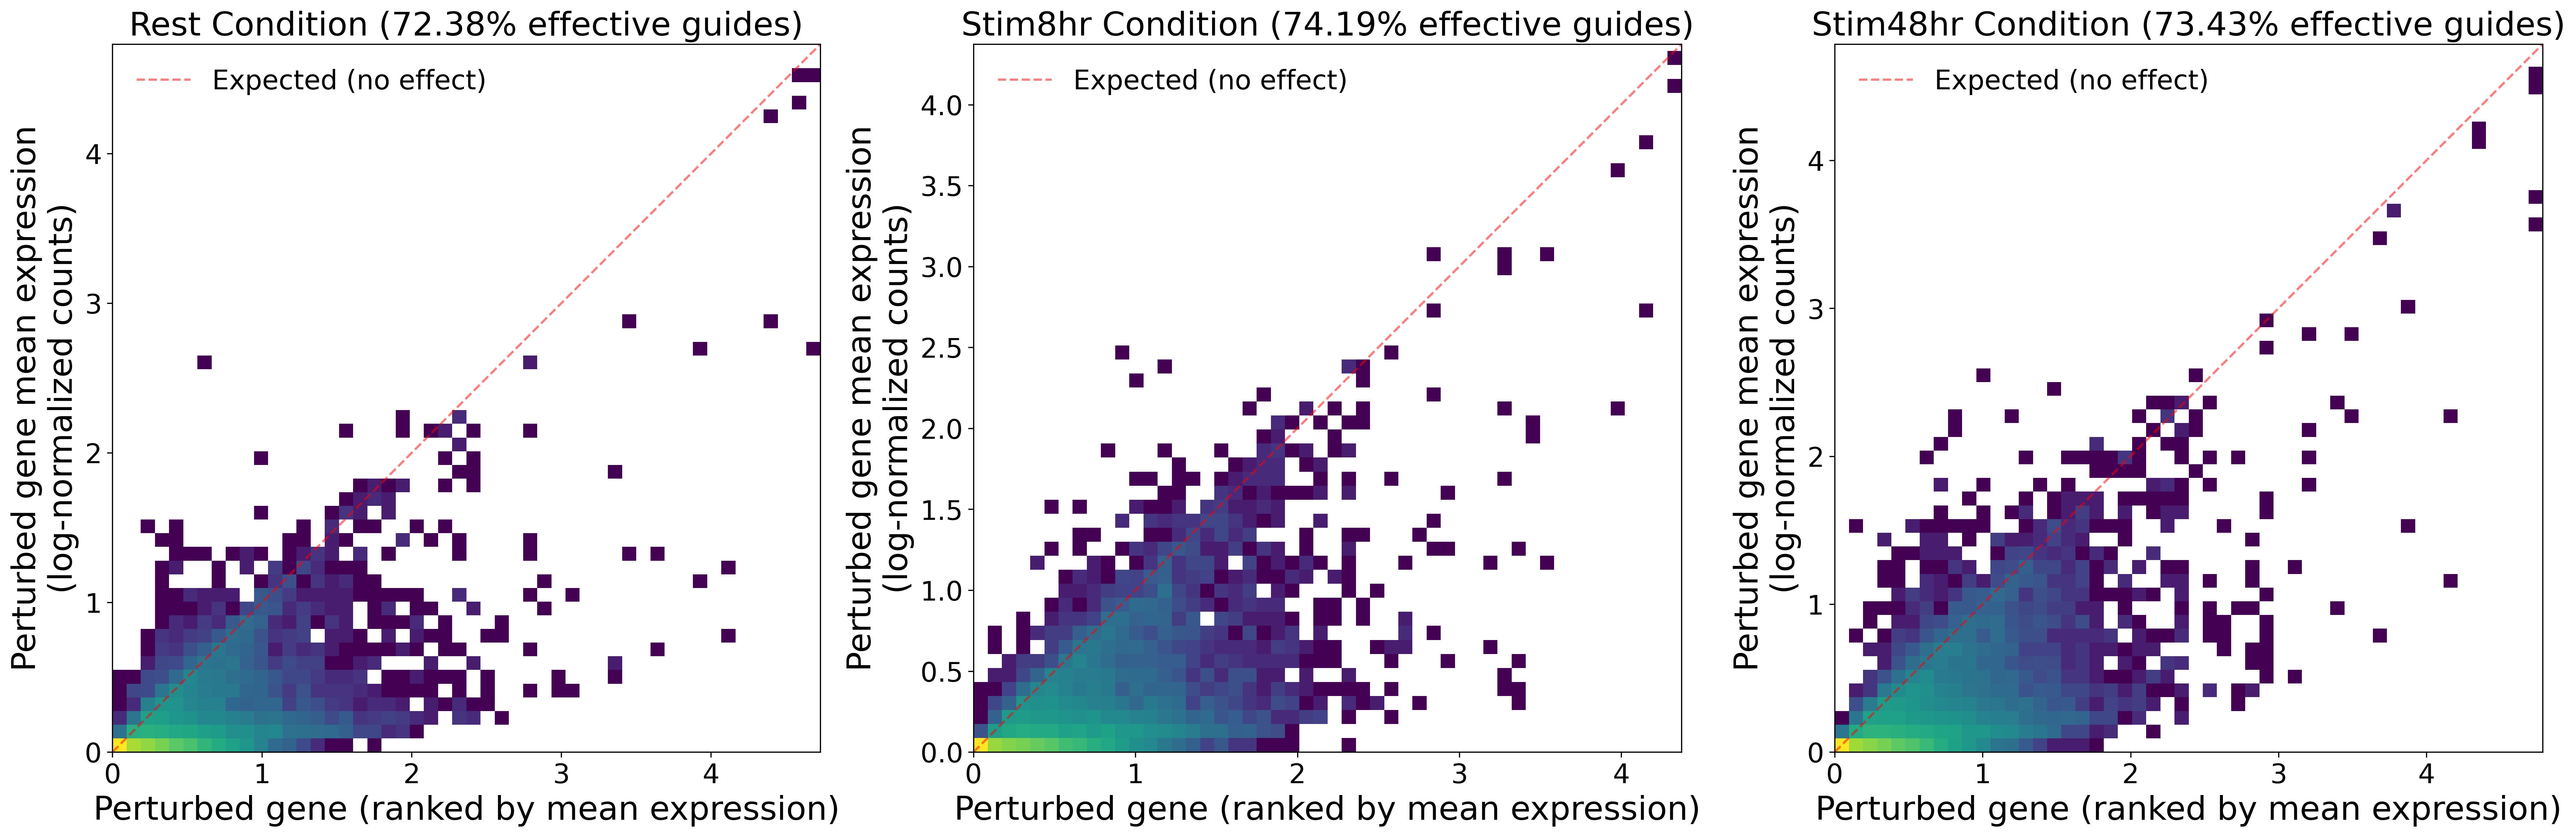

In [145]:
# Function to create the plot for a given dataframe and axis
def plot_expression_rank(df, ax, title):
    # Get unique perturbed genes and their mean NTC expression
    gene_ntc_means = df.groupby('perturbed_gene_id')['ntc_mean_expr'].mean()
    # Rank the perturbed genes by their mean NTC expression
    gene_ranks = gene_ntc_means.rank()
    # Map the gene ranks back to the original dataframe
    df['rank'] = df['perturbed_gene_id'].map(gene_ranks)

    # # Plot mean NTC expression with error bars
    # ax.errorbar(df['guide_mean_expr'],
    #             df['ntc_mean_expr'], 
    #             yerr=df['ntc_std_expr'], 
    #             fmt='o',
    #             color='grey',
    #             markersize=3, 
    #             alpha=0.01,
    #             label='NT control cells',
    #             rasterized=True)

    # Create 2D histogram
    ax.hist2d(df['ntc_mean_expr'], df['guide_mean_expr'],
               bins=50, cmap='viridis', 
               norm=matplotlib.colors.LogNorm(),
               rasterized=True)
    
    # # Add colorbar
    # plt.colorbar(ax=ax, label='Number of guides')
    
    # Add diagonal line
    max_val = max(df['guide_mean_expr'].max(), df['ntc_mean_expr'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    
    # Add legend
    ax.legend(['Expected (no effect)'],
              loc='upper left', frameon=False, fontsize=18)
    # Set equal limits to maintain proportional ratios
    max_val = max(df['guide_mean_expr'].max(), df['ntc_mean_expr'].max())
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    ax.set_xlabel('Perturbed gene (ranked by mean expression)', fontsize=22)
    ax.set_ylabel('Perturbed gene mean expression\n(log-normalized counts)', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(title, fontsize=22)
    ax.set_aspect('equal')  # Ensure square aspect ratio


# Create figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))

# Plot for all conditions
plot_expression_rank(rest_ttest_df, ax1, f'Rest Condition ({np.round((rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim_ttest_df, ax2, f'Stim8hr Condition ({np.round((stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim48_ttest_df, ax3, f'Stim48hr Condition ({np.round((stim48_ttest_df.signif_knockdown.value_counts()[True]/stim48_ttest_df.shape[0])*100, 2)}% effective guides)')

plt.tight_layout()

In [146]:
df.sort_values('perturbed_gene_id')[0:30]

guide_mean_expr  guide_std_expr  guide_n  ntc_mean_expr  \
AKAP2-2            0.000000        0.000000    354.0       0.000000   
AKAP2-2            0.000000        0.000000    286.0       0.000000   
AKAP2-1            0.000000        0.000000    888.0       0.000000   
AKAP2-1            0.000000        0.000000    833.0       0.000000   
AKAP2-2            0.000000        0.000000    286.0       0.000000   
AKAP2-1            0.000000        0.000000    902.0       0.000000   
TSPAN6-1           0.000000        0.000000    226.0       0.000051   
TSPAN6-1           0.000000        0.000000    196.0       0.000251   
TSPAN6-1           0.000000        0.000000    232.0       0.000062   
TSPAN6-2           0.000000        0.000000    454.0       0.000062   
TSPAN6-2           0.000000        0.000000    487.0       0.000051   
TSPAN6-2           0.000000        0.000000    446.0       0.000251   
DPM1-2             0.191385        0.370614    181.0       0.701612   
DPM1-1             0.525955        0.638979    505.0       1.136883   
DPM1-2             0.538714        0.648058    247.0       1.136883   
DPM1-1             0.348582        0.522558    448.0       1.145454   
DPM1-1             0.210970        0.386708    442.0       0.701612   
DPM1-2             0.357621        0.530943    218.0       1.145454   
SCYL3-1            0.115559        0.288588    215.0       0.214139   
SCYL3-2            0.000000        0.000000     64.0       0.241116   
SCYL3-1            0.131248        0.287653    209.0       0.232297   
SCYL3-2            0.006779        0.062135     84.0       0.214139   
SCYL3-2            0.044332        0.197922     59.0       0.232297   
SCYL3-1            0.121462        0.298340    240.0       0.241116   
C1orf112-2         0.178540        0.402459    159.0       0.571550   
C1orf112-1         0.044653        0.192577   1167.0       0.381000   
C1orf112-1         0.045154        0.183444   1149.0       0.338920   
C1orf112-1         0.053548        0.203973   1055.0       0.571550   
C1orf112-2         0.102778        0.316915    144.0       0.381000   
C1orf112-2         0.095229        0.297450    199.0       0.338920   

            ntc_std_expr     ntc_n  t_statistic        p_value   adj_p_value  \
AKAP2-2         0.000000  322089.0          NaN            NaN           NaN   
AKAP2-2         0.000000  303457.0          NaN            NaN           NaN   
AKAP2-1         0.000000  303457.0          NaN            NaN           NaN   
AKAP2-1         0.000000  322089.0          NaN            NaN           NaN   
AKAP2-2         0.000000  313989.0          NaN            NaN           NaN   
AKAP2-1         0.000000  313989.0          NaN            NaN           NaN   
TSPAN6-1        0.005831  322089.0    -5.003551   5.631337e-07  7.807888e-07   
TSPAN6-1        0.014684  303457.0    -9.420356   4.525514e-21  1.000000e-16   
TSPAN6-1        0.006722  313989.0    -5.165458   2.399972e-07  3.309310e-07   
TSPAN6-2        0.006722  313989.0    -5.165458   2.399972e-07  3.309310e-07   
TSPAN6-2        0.005831  322089.0    -5.003551   5.631337e-07  7.807888e-07   
TSPAN6-2        0.014684  303457.0    -9.420356   4.525514e-21  1.000000e-16   
DPM1-2          0.553053  313989.0   -18.509846   1.448226e-43  1.000000e-16   
DPM1-1          0.652333  322089.0   -21.468146   3.744531e-73  1.000000e-16   
DPM1-2          0.652333  322089.0   -14.500720   7.238959e-35  1.000000e-16   
DPM1-1          0.611811  303457.0   -32.244387  6.423405e-119  1.000000e-16   
DPM1-1          0.553053  313989.0   -26.635919   4.679750e-94  1.000000e-16   
DPM1-2          0.611811  303457.0   -21.898162   6.563133e-57  1.000000e-16   
SCYL3-1         0.381012  322089.0    -5.005856   1.158427e-06  1.596854e-06   
SCYL3-2         0.402941  303457.0  -329.635088   0.000000e+00  1.000000e-16   
SCYL3-1         0.387988  313989.0    -5.075455   8.543098e-07  1.165870e-06   
SCYL3-2         0.381012  322089.0   -30.437534   

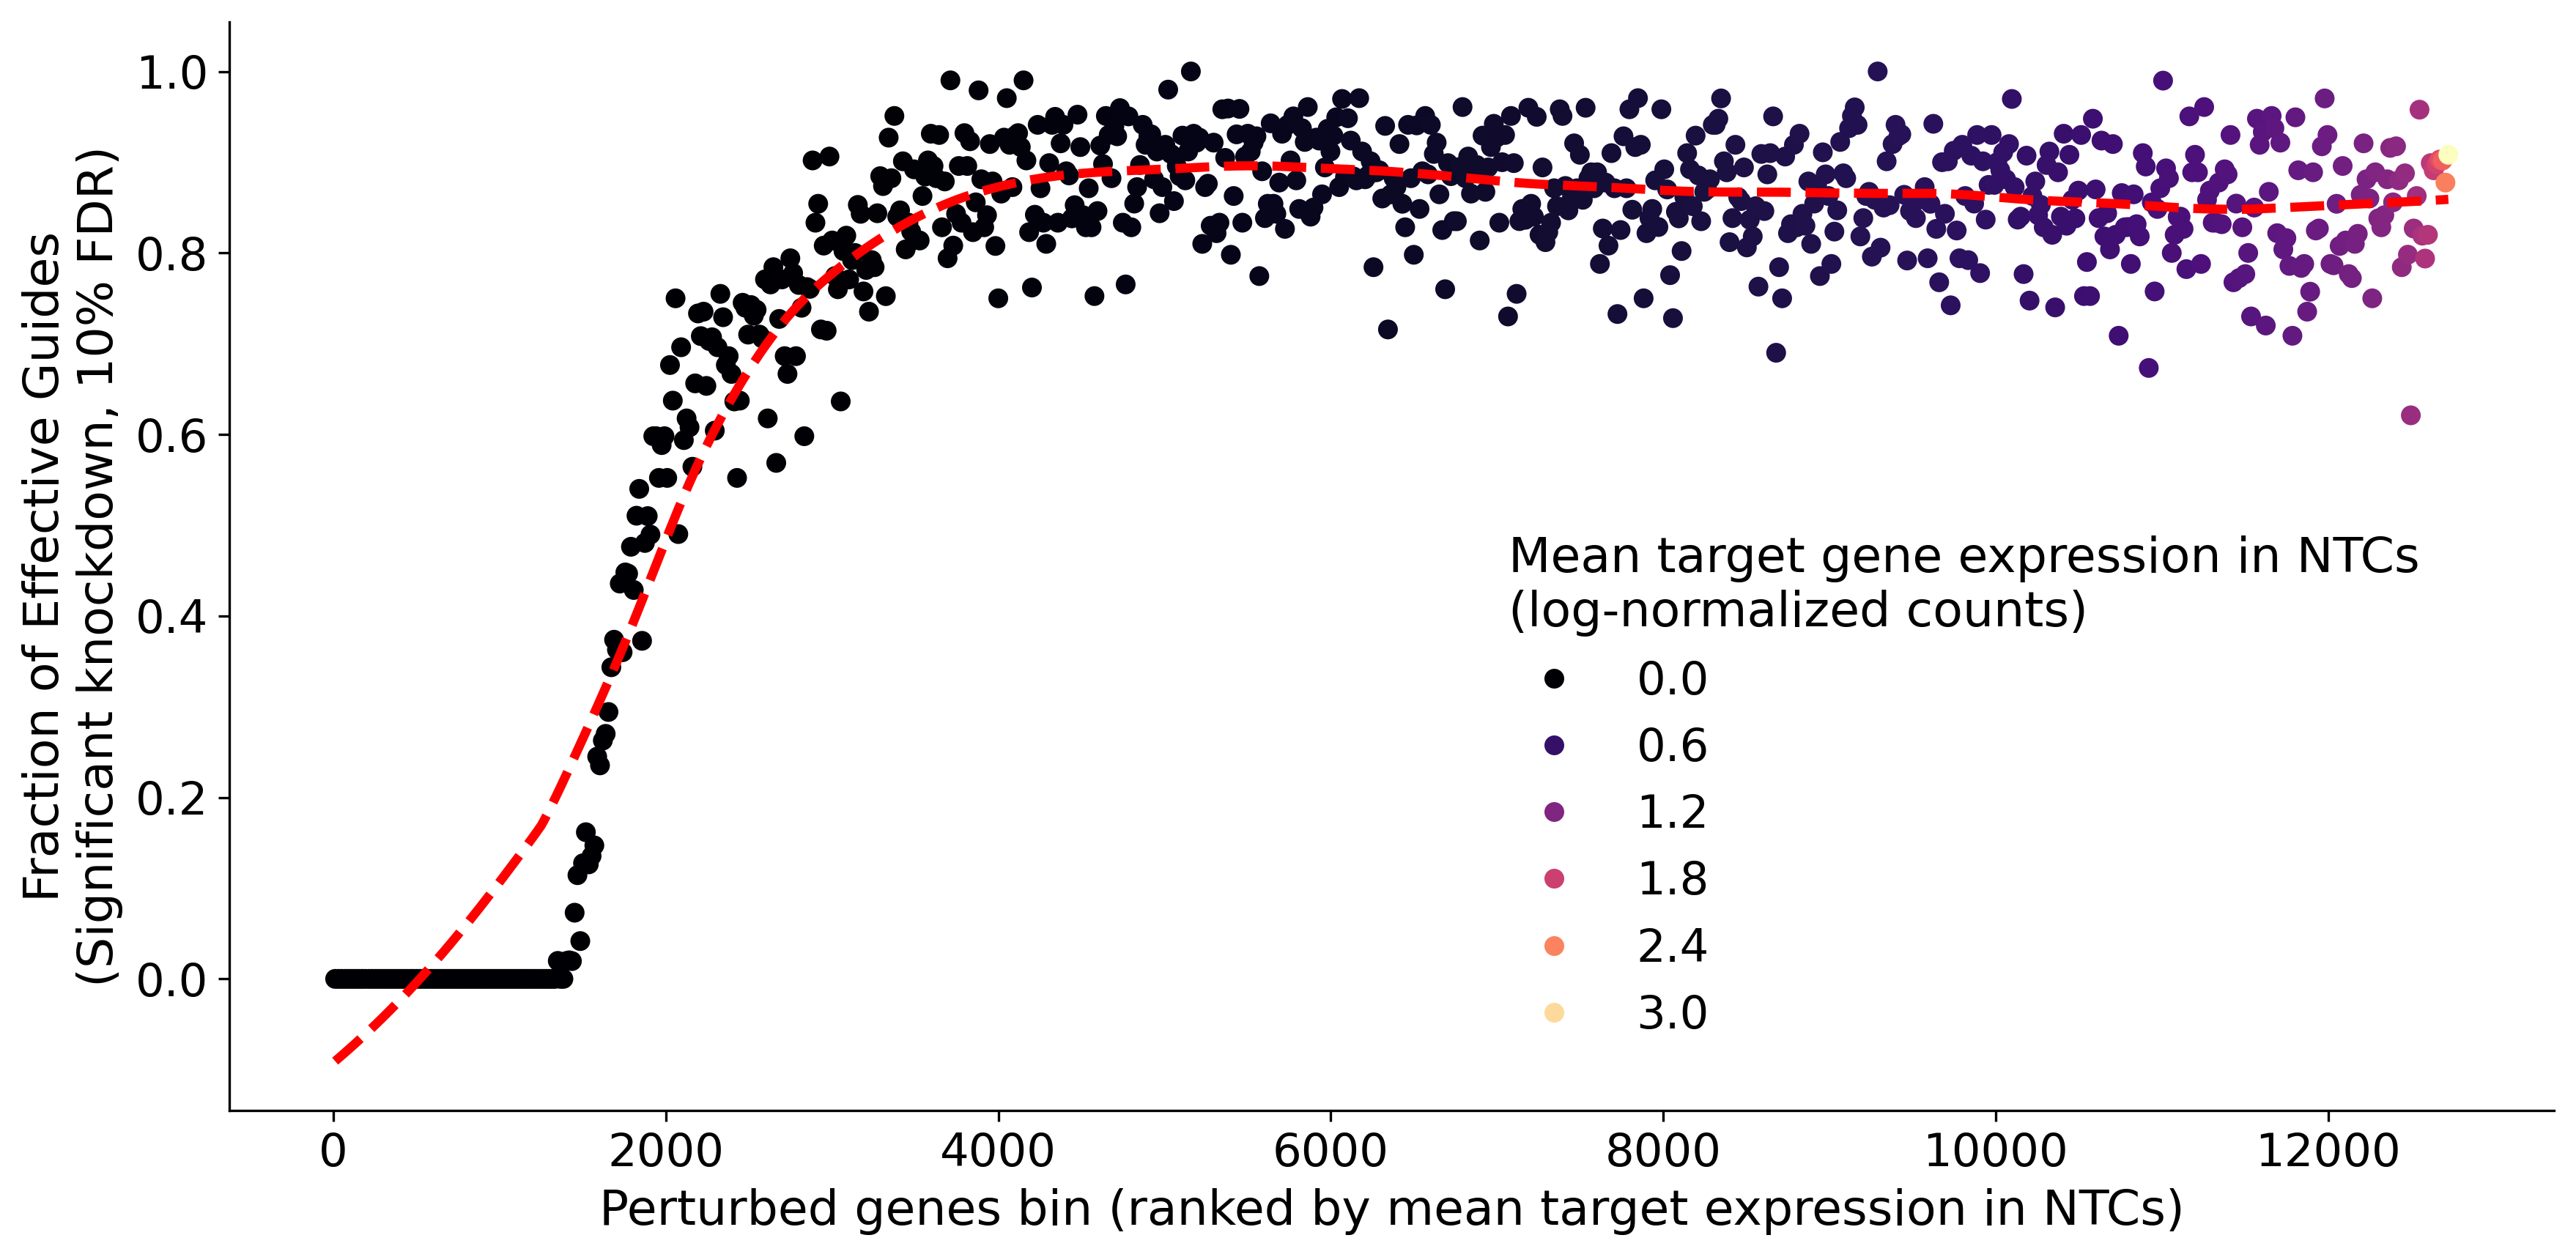

In [152]:
df = pd.concat([rest_ttest_df, stim_ttest_df, stim48_ttest_df])

# Get unique perturbed genes and their mean NTC expression
gene_ntc_means = df.groupby('perturbed_gene_id')['ntc_mean_expr'].mean()
# Rank the perturbed genes by their mean NTC expression, using method='first' to handle ties
gene_ranks = gene_ntc_means.rank(method='first')
# Map the gene ranks back to the original dataframe
df['rank'] = df['perturbed_gene_id'].map(gene_ranks)

# Calculate fraction of significant knockdowns and mean expression in bins of 100 ranks
df['rank_bin'] = pd.qcut(df['rank'], q=len(df)//100, labels=False)
bin_stats = df.groupby('rank_bin').agg({
    'rank': 'mean', 
    'signif_knockdown': 'mean', 
    'ntc_mean_expr': 'mean',
    'guide_mean_expr': 'mean',
    'guide_n':'mean',
    'ntc_n':'mean',
    'perturbed_gene_id': 'nunique'
}).reset_index()

# Create figure with larger width
plt.figure(figsize=(12, 6))

# Create scatter plot
g = sns.scatterplot(data=bin_stats, x='rank', y='signif_knockdown', 
                    hue='ntc_mean_expr', edgecolor=None, palette='magma')

# Add LOESS trend line
from statsmodels.nonparametric.smoothers_lowess import lowess
smooth = lowess(bin_stats.signif_knockdown, bin_stats['rank'], frac=0.2)
plt.plot(smooth[:, 0], smooth[:, 1], color='red', linestyle='--', linewidth=3)

plt.xlabel('Perturbed genes bin (ranked by mean target expression in NTCs)')
plt.ylabel('Fraction of Effective Guides\n(Significant knockdown, 10% FDR)')

# Move legend to bottom right corner
plt.legend(title='Mean target gene expression in NTCs\n(log-normalized counts)', bbox_to_anchor=(0.95, 0.05),
          loc='lower right', borderaxespad=0, frameon=False, ncols=1, alignment='left')

sns.despine()
plt.tight_layout()
plt.savefig('./results/guide_effect_binned.pdf')
plt.savefig('./results/guide_effect_binned.png')

<Axes: xlabel='rank_bin', ylabel='guide_mean_expr'>

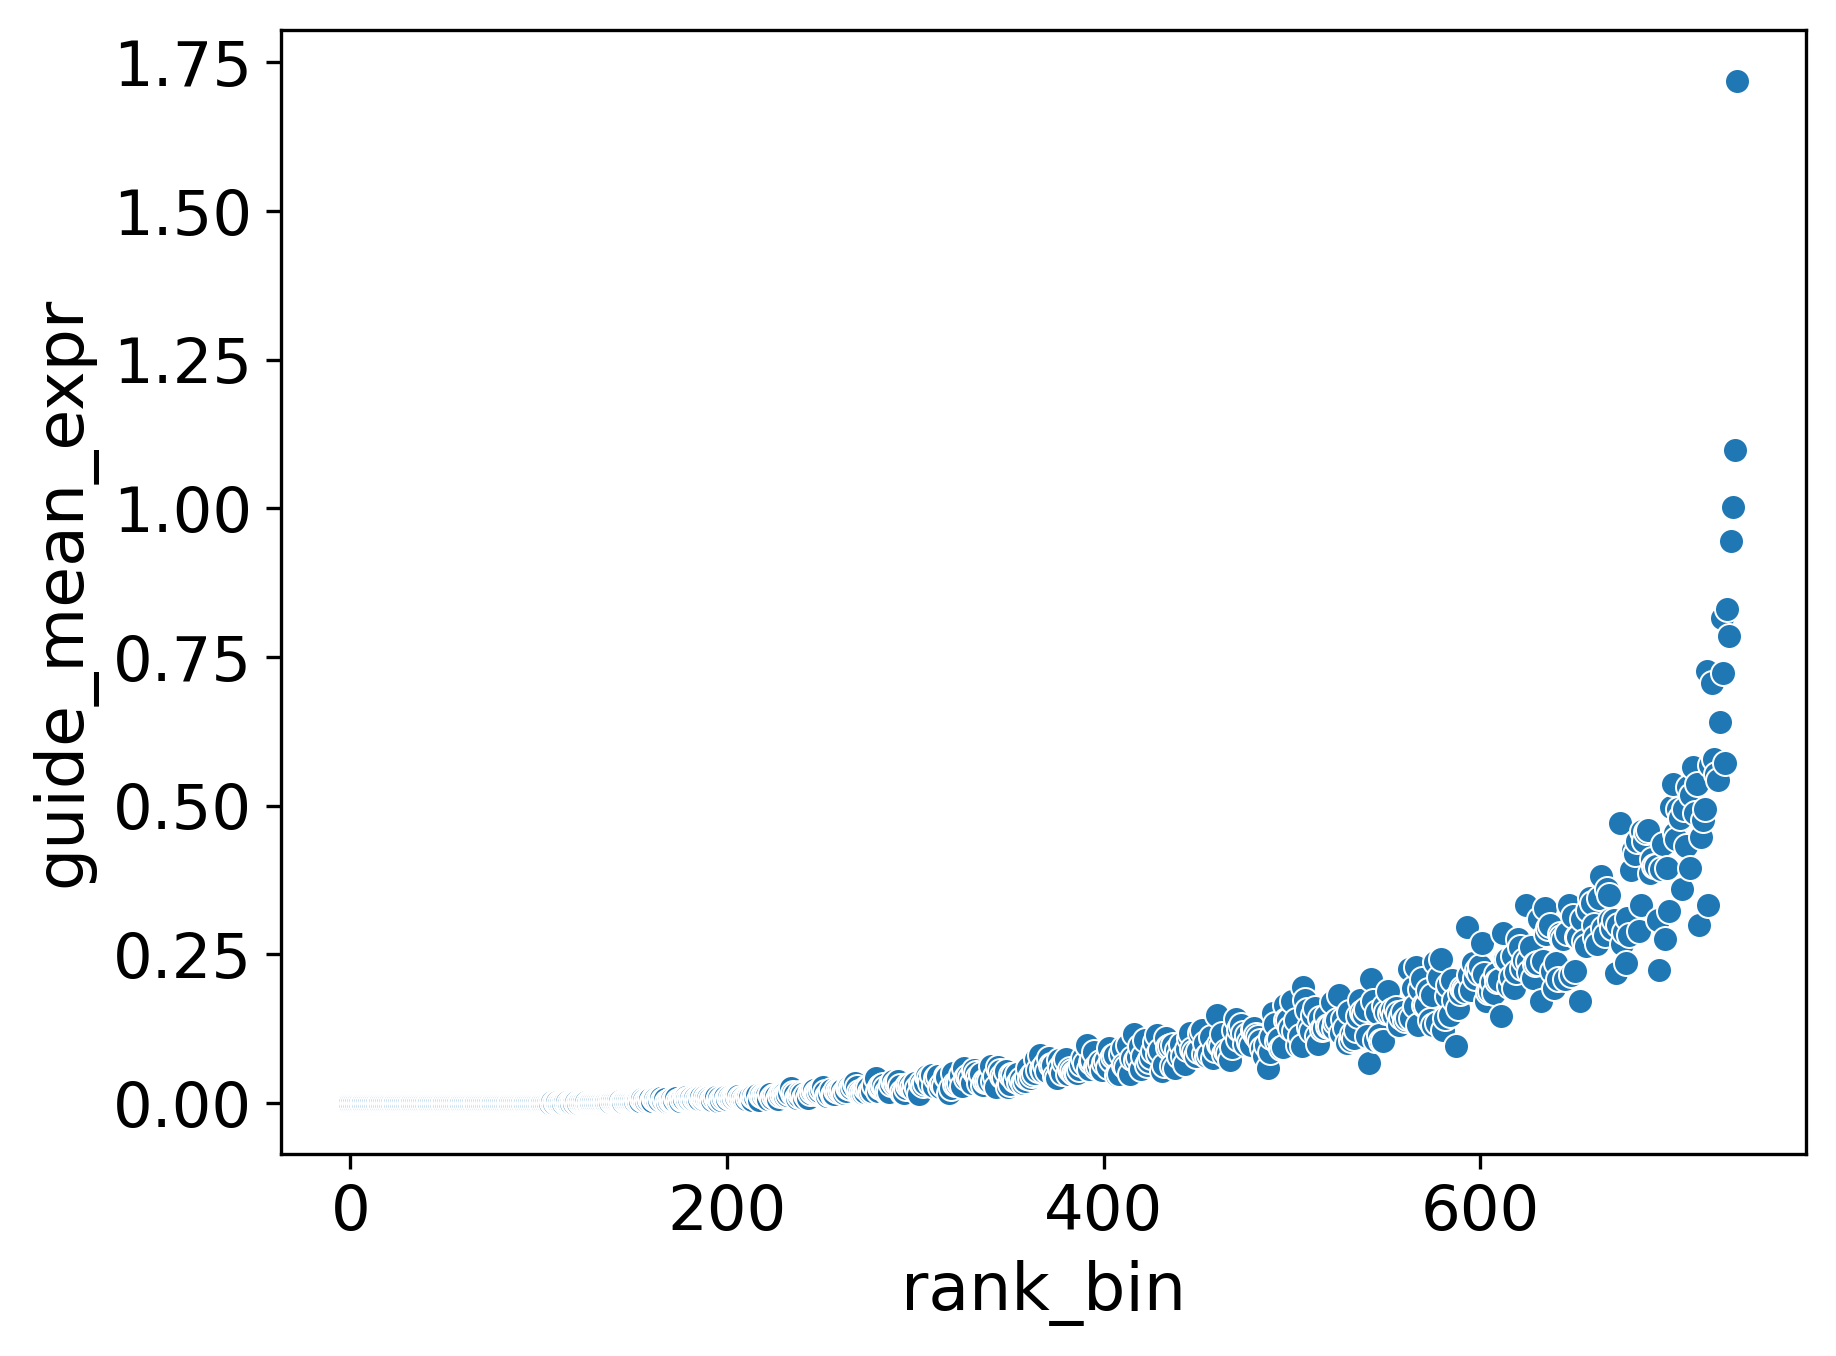

In [111]:
sns.scatterplot(data=bin_stats, x='rank_bin', y='guide_mean_expr')

In [98]:
bin_stats[bin_stats['rank_bin'].isin(np.arange(40,70))]

rank_bin         rank  signif_knockdown  ntc_mean_expr
40        40   726.060606          0.222222       0.000006
41        41   743.000000          0.333333       0.000007
42        42   759.500000          0.375000       0.000008
43        43   776.019802          0.425743       0.000009
44        44   793.000000          0.333333       0.000010
45        45   809.500000          0.437500       0.000011
46        46   826.881188          0.594059       0.000012
47        47   844.000000          0.607843       0.000013
48        48   861.000000          0.627451       0.000014
49        49   877.878788          0.646465       0.000015
50        50   895.000000          0.647059       0.000016
51        51   911.500000          0.625000       0.000017
52        52   928.000000          0.754902       0.000018
53        53   945.120000          0.790000       0.000020
54        54   962.294118          0.862745       0.000021
55        55   979.500000          0.875000       0.000023
56        56   996.000000          0.941176       0.000024
57        57  1013.000000          0.833333       0.000027
58        58  1029.845361          0.989691       0.000030
59        59  1047.000000          0.803922       0.000033
60        60  1064.000000          0.843137       0.000037
61        61  1080.500000          0.812500       0.000040
62        62  1097.090909          0.878788       0.000043
63        63  1114.000000          0.970588       0.000048
64        64  1131.000000          0.980392       0.000056
65        65  1147.500000          0.968750       0.000063
66        66  1163.990099          0.960396       0.000068
67        67  1181.000000          0.980392       0.000074
68        68  1198.030303          0.909091       0.000083
69        69  1215.090909          0.919192       0.000092

In [112]:
df[df['rank_bin'] == 58]

guide_mean_expr  guide_std_expr  guide_n  ntc_mean_expr  \
ARHGAP24-2               0.0             0.0    368.0       0.000023   
CD36-1                   0.0             0.0    206.0       0.000005   
CD36-2                   0.0             0.0    489.0       0.000005   
DMRTA1-1                 0.0             0.0    180.0       0.000016   
DMRTA1-2                 0.0             0.0    400.0       0.000016   
...                      ...             ...      ...            ...   
TNFRSF13B-1              0.0             0.0    247.0       0.000058   
ZNF214-1                 0.0             0.0     54.0       0.000064   
ARHGAP24-1               0.0             0.0     62.0       0.000030   
IRX1-2                   0.0             0.0    141.0       0.000017   
TREX2-2                  0.0           100.0      1.0       0.000031   

             ntc_std_expr     ntc_n   t_statistic   p_value  adj_p_value  \
ARHGAP24-2       0.004444  313989.0 -2.920931e+00  0.003490     0.004355   
CD36-1           0.001621  313989.0 -1.722098e+00  0.085053     0.098639   
CD36-2           0.001621  313989.0 -1.722098e+00  0.085053     0.098639   
DMRTA1-1         0.003251  313989.0 -2.802143e+00  0.005077     0.006290   
DMRTA1-2         0.003251  313989.0 -2.802143e+00  0.005077     0.006290   
...                   ...       ...           ...       ...          ...   
TNFRSF13B-1      0.006723  322089.0 -4.872065e+00  0.000001     0.000002   
ZNF214-1         0.008432  322089.0 -4.284814e+00  0.000018     0.000025   
ARHGAP24-1       0.006155  322089.0 -2.806540e+00  0.005008     0.006205   
IRX1-2           0.003764  322089.0 -2.568074e+00  0.010227     0.012485   
TREX2-2          0.004945  322089.0 -3.110269e-07       NaN          NaN   

             signif_knockdown perturbed_gene_id    rank  rank_bin  
ARHGAP24-2               True   ENSG00000138639  1026.0        58  
CD36-1                   True   ENSG00000135218  1023.0        58  
CD36-2                   True   ENSG00000135218  1023.0        58  
DMRTA1-1                 True   ENSG00000176399  1032.0        58  
DMRTA1-2                 True   ENSG00000176399  1032.0        58  
...                       ...               ...     ...       ...  
TNFRSF13B-1              True   ENSG00000240505  1035.0        58  
ZNF214-1                 True   ENSG00000149050  1025.0        58  
ARHGAP24-1               True   ENSG00000138639  1026.0        58  
IRX1-2                   True   ENSG00000170549  1022.0        58  
TREX2-2                 False   ENSG00000183479  1033.0        58  

[97 rows x 13 columns]

<Axes: xlabel='rank_bin', ylabel='ntc_mean_expr'>

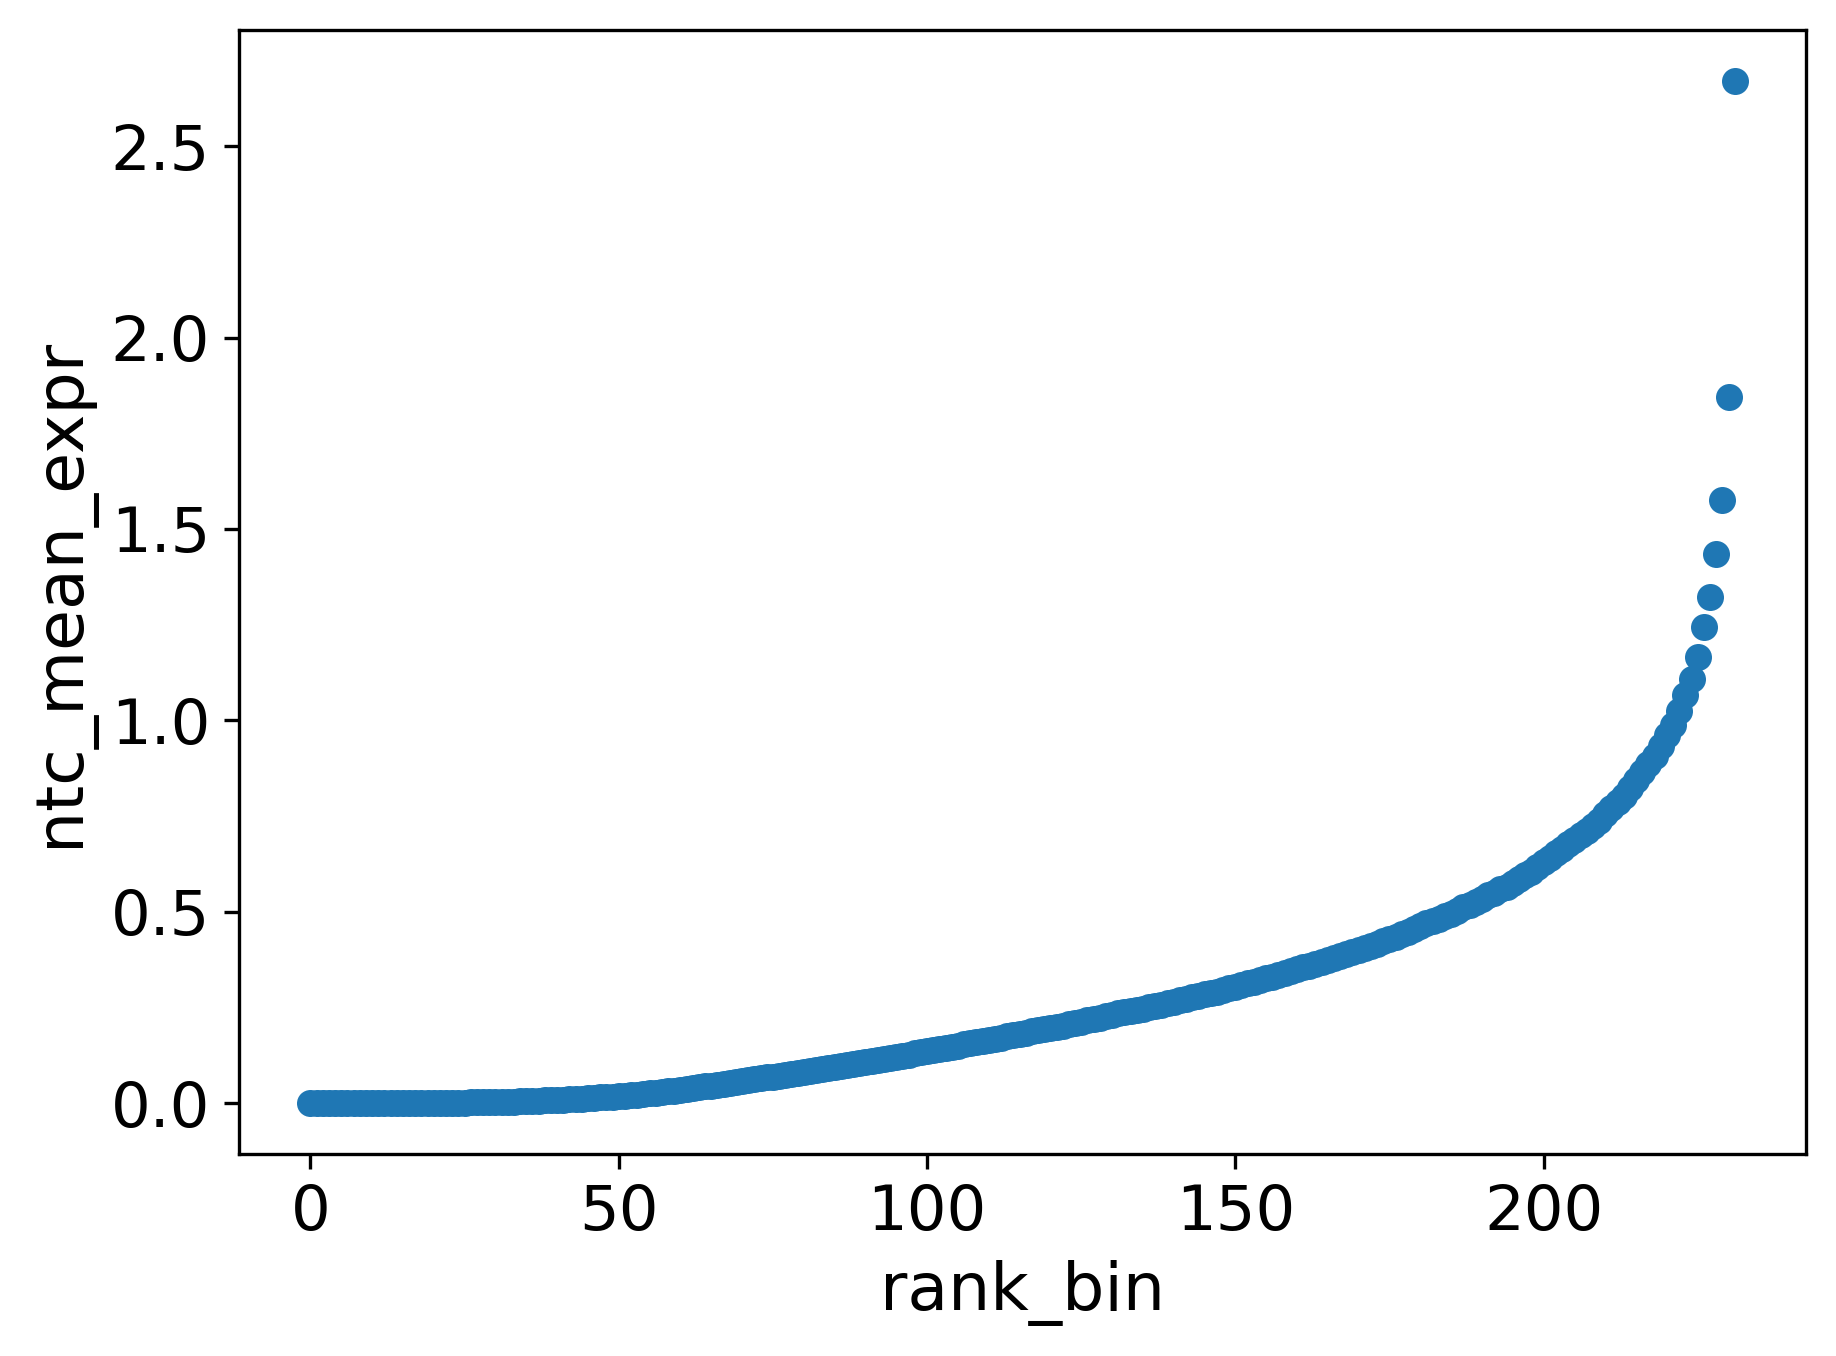

In [40]:
sns.scatterplot(data=bin_stats, x='rank_bin', y='ntc_mean_expr', edgecolor=None, palette='magma')

In [10]:
st = 'signif_knockdown'
compare_df = pd.concat([stim_ttest_df[st], stim48_ttest_df[st]], axis=1)
compare_df.columns = ['stim', 'stim48']
pd.crosstab(compare_df['stim'], compare_df['stim48'])

stim48  False  True 
stim                
False    2984   1225
True     1519  18659

<Axes: xlabel='stim', ylabel='stim48'>

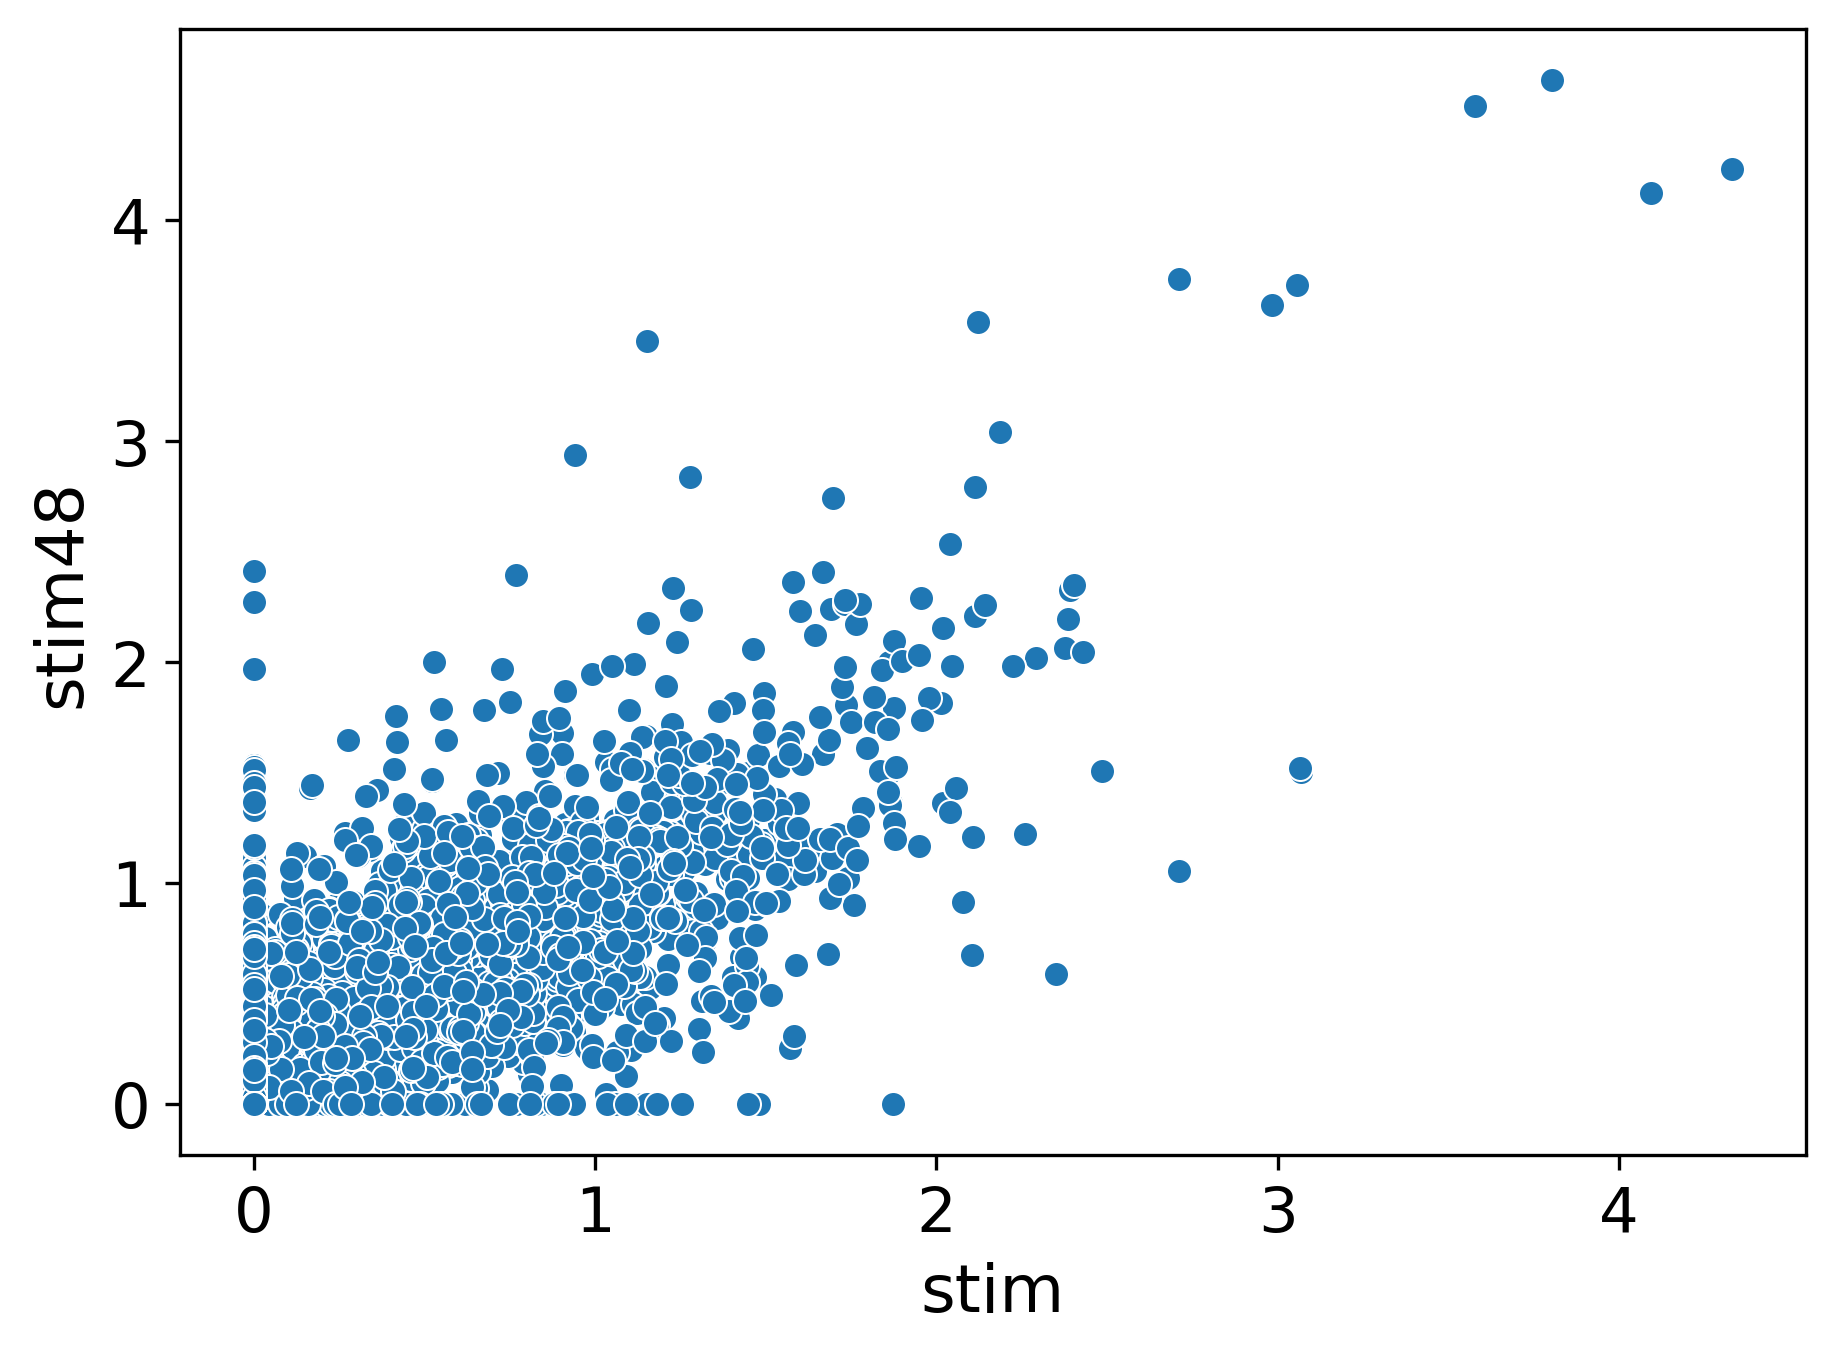

In [19]:
st = 'guide_mean_expr'
compare_df = pd.concat([stim_ttest_df[st], stim48_ttest_df[st]], axis=1)
compare_df.columns = ['stim', 'stim48']
sns.scatterplot(data=compare_df, x='stim', y='stim48')

In [20]:
print(stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])
print(stim48_ttest_df.signif_knockdown.value_counts()[True]/stim48_ttest_df.shape[0])
print(rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])

0.8210598761183757
0.8100256337225862
0.8029158328909217


In [21]:
rest_ttest_df['high_confidence_no_effect_guides'] = (~rest_ttest_df['signif_knockdown']) & (rest_ttest_df.guide_n > 10) & (rest_ttest_df.ntc_mean_expr > 0)
stim_ttest_df['high_confidence_no_effect_guides'] = (~stim_ttest_df['signif_knockdown']) & (stim_ttest_df.guide_n > 10) & (stim_ttest_df.ntc_mean_expr > 0)
stim48_ttest_df['high_confidence_no_effect_guides'] = (~stim48_ttest_df['signif_knockdown']) & (stim48_ttest_df.guide_n > 10) & (stim48_ttest_df.ntc_mean_expr > 0)

In [22]:
def plot_kd(mean_perturbed_gene_expr_df, top_n=100, figsize=(15,6), show_xlabels=True):
    # Group by guide_id instead of perturbed_gene
    guide_means = mean_perturbed_gene_expr_df.copy()

    # Select a subset of guides to plot (to avoid overcrowding)
    pl_df = guide_means.head(top_n)  # Take first 100 guides or adjust as needed
    pl_df
    plt.figure(figsize=figsize)
    # Plot mean NTC expression with error bars
    plt.errorbar(pl_df['guide_id'],
                pl_df['ntc_mean_expr'], 
                yerr=pl_df['ntc_std_expr'],
                fmt='o',
                color='grey',
                markersize=2,
                alpha=0.5,
                label='NT control cells')

    # Add stripplot of perturbed expression
    plt.errorbar(pl_df['guide_id'],
            pl_df['guide_mean_expr'],
            yerr=pl_df['guide_std_expr'],
            fmt='o',
            markersize=2,
            color='blue',
            alpha=0.5,
            label='Perturbed cells')

    if show_xlabels:
        plt.xticks(rotation=90)
    else:
        plt.xticks([])
    plt.ylim(0)
    plt.xlabel('Guide ID')
    plt.ylabel('Perturbed gene expression (log-normalized counts)')
    plt.legend(frameon=False)
    plt.tight_layout()

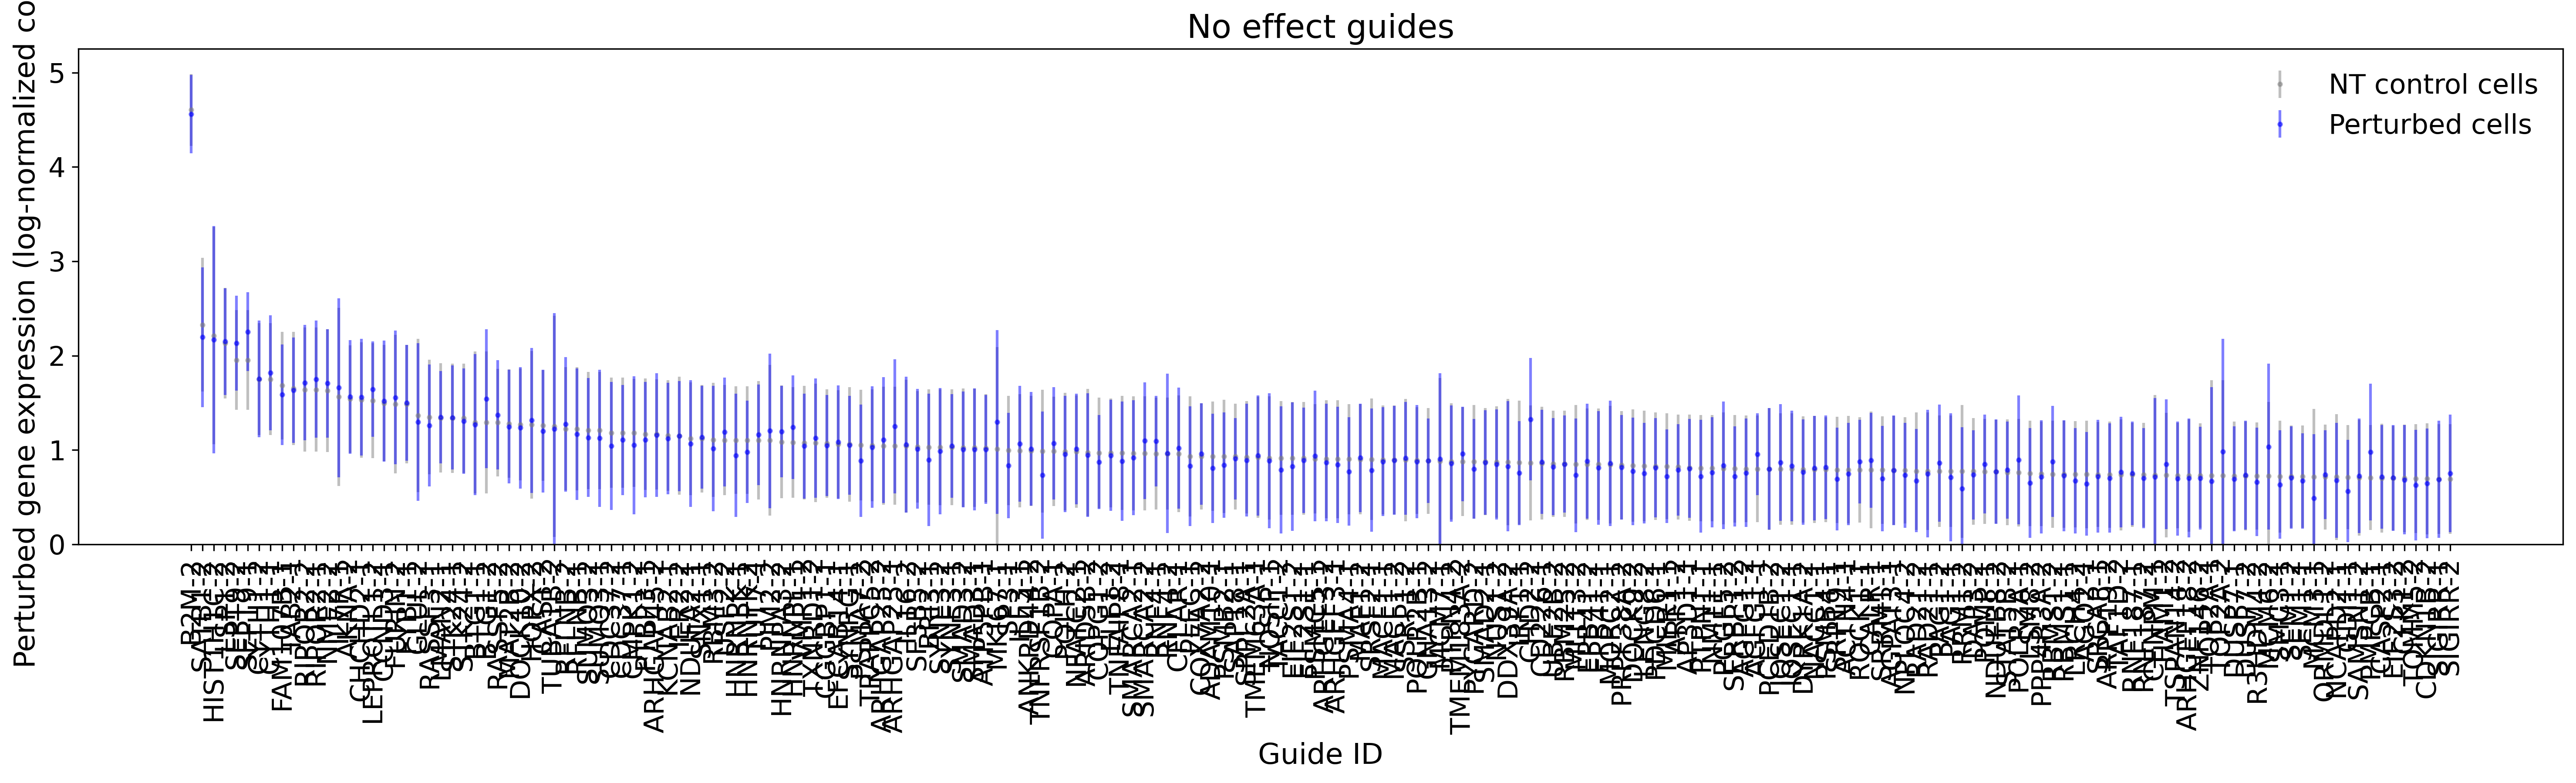

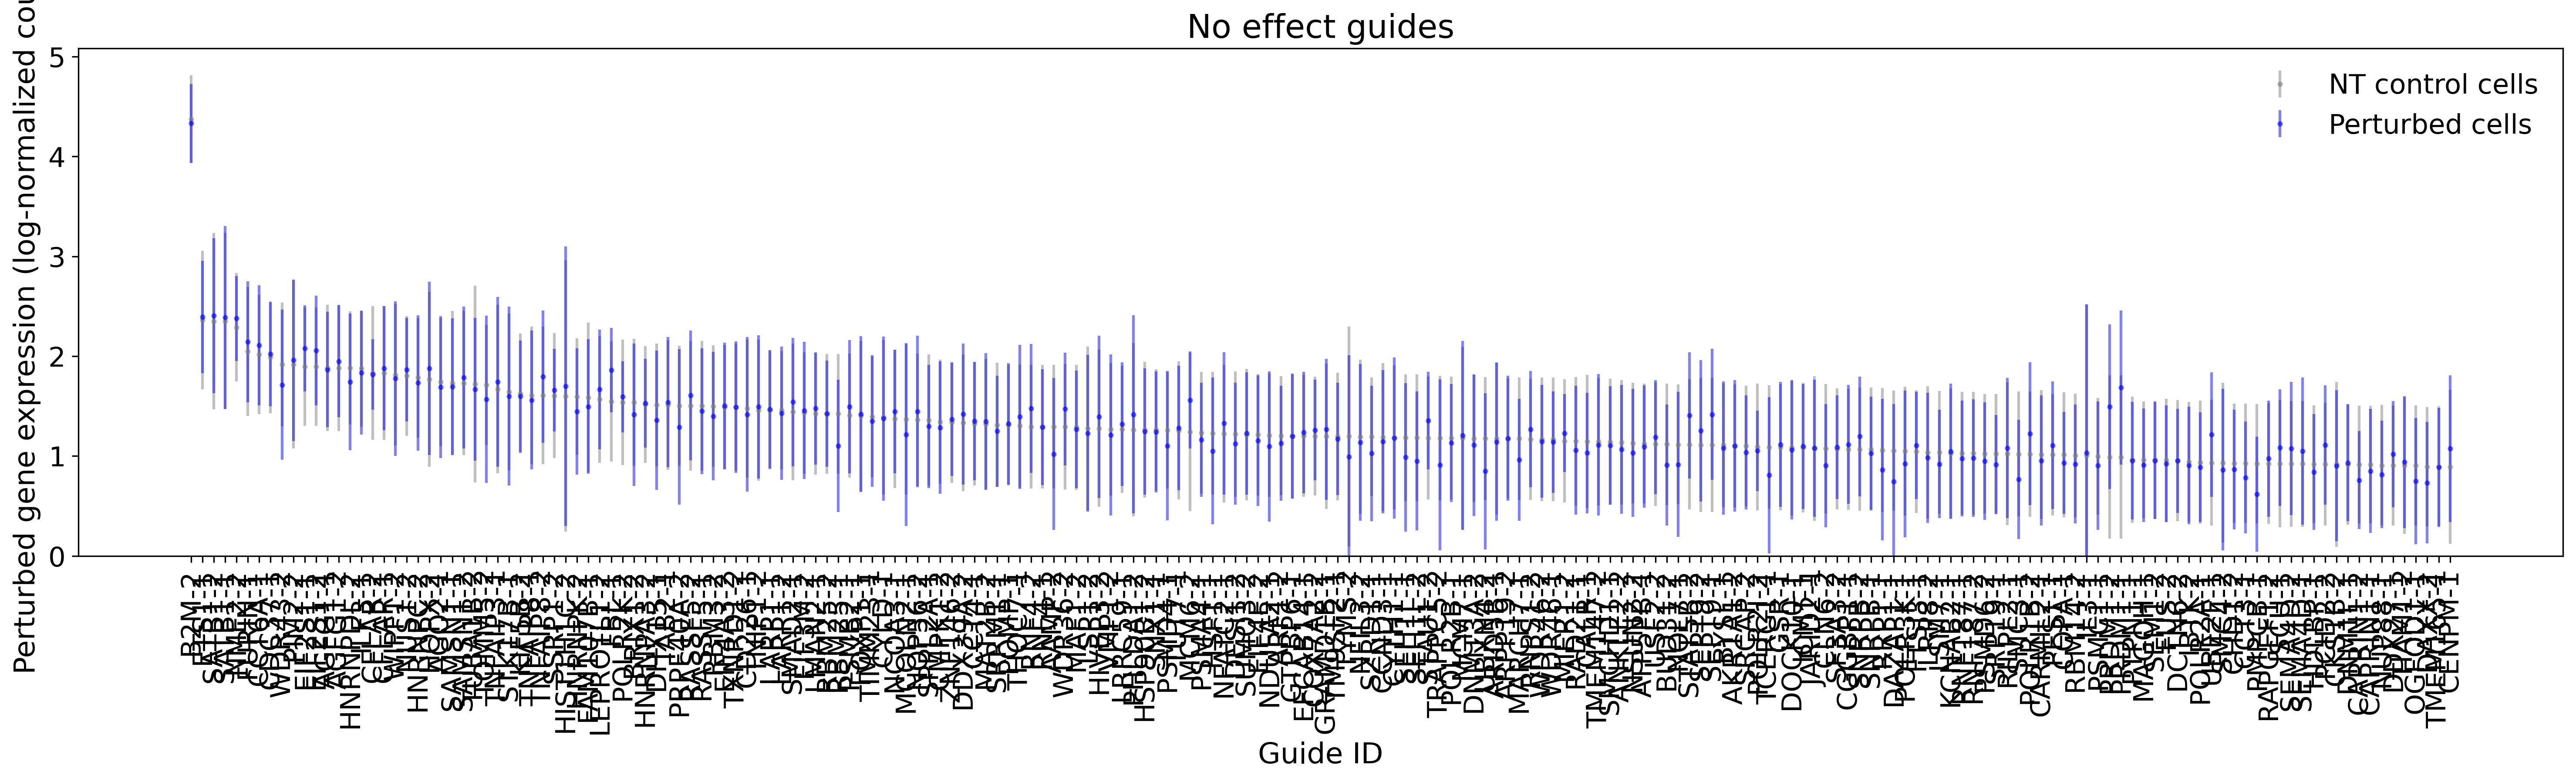

In [23]:
pl_df = rest_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[rest_ttest_df.high_confidence_no_effect_guides.values]
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(20,6))
plt.title('No effect guides')
plt.show()

pl_df = stim_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[stim_ttest_df.high_confidence_no_effect_guides.values]
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(20,6))
plt.title('No effect guides')
plt.show()

### Save list of putative ineffective guides (across conditions)

In [24]:
no_effect_guides = np.intersect1d(rest_ttest_df.index[rest_ttest_df['high_confidence_no_effect_guides']], stim_ttest_df.index[stim_ttest_df['high_confidence_no_effect_guides']])
no_effect_guides = np.intersect1d(no_effect_guides, stim48_ttest_df.index[stim48_ttest_df['high_confidence_no_effect_guides']])
no_effect_guides = no_effect_guides.tolist()
print(len(no_effect_guides))

921


In [59]:
sgrna_library_metadata_clean.loc[no_effect_guides].columns

Index(['chromosome', 'pos', 'seq_last19bp', 'strand', 'PAM', 'note', 'flag',
       'seq', 'target_gene_name_from_sgRNA', 'designed_target_gene_id',
       'designed_target_gene_name', 'target_gene_id', 'target_gene_name',
       'distance_to_closest_target_tss', 'nearby_gene_within_2kb',
       'nearby_gene_within_10kb', 'nearby_gene_within_20kb',
       'nearby_gene_within_30kb', 'nearest_within2kb_gene_id',
       'nearest_within2kb_gene_name', 'nearest_within2kb_gene_dist',
       'nearest_within2kb_nontarget_gene_id',
       'nearest_within2kb_nontarget_gene_name',
       'nearest_within2kb_nontarget_gene_dist',
       'putative_bidirectional_promoter', 'other_alignment_chromosome',
       'other_alignment_pos', 'nearest_nontarget_gene_id',
       'nearest_nontarget_gene_name', 'nearest_nontarget_gene_dist'],
      dtype='object')

In [27]:
# Save no_effect_guides to a text file
with open(os.path.join(results_dir, 'no_effect_guides.txt'), 'w') as f:
    for guide in no_effect_guides:
        f.write(f"{guide}\n")


In [28]:
len(no_effect_guides)

921